# imports

In [1]:
%matplotlib inline
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import gym
import random
import numpy as np   
import matplotlib.pyplot as plt
import collections

# Import Tensorflow libraries

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers.legacy import Adam

#import early stopping
from tensorflow.keras.callbacks import EarlyStopping

from IPython.display import HTML

from tqdm import tqdm

tqdm.pandas()

# disable eager execution (optimization)
# from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()

# ###### Tensorflow-GPU ########

# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)


## Environment

In [80]:
import numpy as np

import gym
from gym import spaces

import pygame

class RCMazeEnv(gym.Env):
    def __init__(self, maze_size_x=12, maze_size_y=12):
        self.maze_size_x = maze_size_x
        self.maze_size_y = maze_size_y
        self.maze = self.generate_maze()
        self.car_position = (1, 1)
        self.possible_actions = range(3)
        self.car_orientation = 'N'
        self.sensor_readings = {'front': 0, 'left': 0, 'right': 0}
        self.steps = 0
        self.previous_distance = 0
        self.goal = (10, 10)
        self.previous_steps = 0
        self.reset()

            
    def generate_maze(self):
        # For simplicity, create a static maze with walls
        # '1' represents a wall, and '0' represents an open path
        maze = np.zeros((self.maze_size_y, self.maze_size_x), dtype=int)
        # Add walls to the maze (this can be customized)

        layout = [
                [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
                [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
                [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1],
                [1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1],
                [1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1],
                [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1],
                [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
        
     
        maze = np.array(layout)

        return maze

    def reset(self):
        self.car_position = (1, 1)
        self.car_orientation = 'N'
        self.update_sensor_readings()
        self.steps = 0
        self.previous_distance = 0
        self.previous_steps = 0
        return self.get_state()

    def step(self, action):
        if action == 0:
            self.move_forward()
        elif action == 1:
            self.turn_left()
        elif action == 2:
            self.turn_right()
        self.update_sensor_readings()
        reward = self.compute_reward()
        self.steps += 1
        done = self.is_done()
        return self.get_state(), reward, done

    
    def move_forward(self):
        x, y = self.car_position
        if self.car_orientation == 'N' and y > 0 and self.maze[y - 1][x] != 1:
            self.car_position = (x, y - 1)
        elif self.car_orientation == 'S' and y < self.maze_size_y - 1 and self.maze[y + 1][x] != 1:
            self.car_position = (x, y + 1)
        elif self.car_orientation == 'E' and x < self.maze_size_x - 1 and self.maze[y][x + 1] != 1:
            self.car_position = (x + 1, y)
        elif self.car_orientation == 'W' and x > 0 and self.maze[y][x - 1] != 1:
            self.car_position = (x - 1, y)
        

    def turn_left(self):
        orientations = ['N', 'W', 'S', 'E']
        idx = orientations.index(self.car_orientation)
        self.car_orientation = orientations[(idx + 1) % 4]

    def turn_right(self):
        orientations = ['N', 'E', 'S', 'W']
        idx = orientations.index(self.car_orientation)
        self.car_orientation = orientations[(idx + 1) % 4]

    def update_sensor_readings(self):
        # Simple sensor implementation: counts steps to the nearest wall
        self.sensor_readings['front'] = self.distance_to_wall('front')
        self.sensor_readings['left'] = self.distance_to_wall('left')
        self.sensor_readings['right'] = self.distance_to_wall('right')

    def distance_to_wall(self, direction):
        x, y = self.car_position
        distance = 0
        max_distance = self.maze_size_x if direction in ['left', 'right'] else self.maze_size_y

        
        if direction == 'front':
            if self.car_orientation == 'N':
                while y - distance >= 0 and self.maze[y - distance][x] != 1:
                    distance += 1
            elif self.car_orientation == 'S':
                while y + distance < self.maze_size_y and self.maze[y + distance][x] != 1:
                    distance += 1
            elif self.car_orientation == 'E':
                while x + distance < self.maze_size_x and self.maze[y][x + distance] != 1:
                    distance += 1
            elif self.car_orientation == 'W':
                while x - distance >= 0 and self.maze[y][x - distance] != 1:
                    distance += 1
        elif direction == 'left':
            if self.car_orientation == 'N':
                while x - distance >= 0 and self.maze[y][x - distance] != 1:
                    distance += 1
            elif self.car_orientation == 'S':
                while x + distance < self.maze_size_x and self.maze[y][x + distance] != 1:
                    distance += 1
            elif self.car_orientation == 'E':
                while y - distance >= 0 and self.maze[y - distance][x] != 1:
                    distance += 1
            elif self.car_orientation == 'W':
                while y + distance < self.maze_size_y and self.maze[y + distance][x] != 1:
                    distance += 1
        elif direction == 'right':
            if self.car_orientation == 'N':
                while x + distance < self.maze_size_x and self.maze[y][x + distance] != 1:
                    distance += 1
            elif self.car_orientation == 'S':
                while x - distance >= 0 and self.maze[y][x - distance] != 1:
                    distance += 1
            elif self.car_orientation == 'E':
                while y + distance < self.maze_size_y and self.maze[y + distance][x] != 1:
                    distance += 1
            elif self.car_orientation == 'W':
                while y - distance >= 0 and self.maze[y - distance][x] != 1:
                    distance += 1
        
            # Normalize the measured distance
        normalized_distance = (max_distance - distance - 1) / (max_distance - 1)

        # Ensure the value is within the range [0, 1]
        normalized_distance = max(0, min(normalized_distance, 1))

        return normalized_distance
    
    def compute_reward(self):
        # # Initialize reward
        reward = 0

        # # Check for collision or out of bounds
        if any(self.sensor_readings[direction] == 0 for direction in ['front', 'left', 'right']):
            reward -= 20

        # # Check if goal is reached
        if self.car_position == self.goal:
            reward += 100
            # Additional penalty if it takes too many steps to reach the goal
            if self.steps > 750:
                reward -= 200
            return reward  # Return immediately as this is the terminal state

        # Calculate the Euclidean distance to the goal
        distance_to_goal = ((self.car_position[0] - self.goal[0]) ** 2 + (self.car_position[1] - self.goal[1]) ** 2) ** 0.5

        # Define a maximum reward when the car is at the goal
        max_reward_at_goal = 50

        # Reward based on proximity to the goal
        reward += max_reward_at_goal / (distance_to_goal + 1)  # Adding 1 to avoid division by zero

        # # Reward or penalize based on movement towards or away from the goal
        if distance_to_goal < self.previous_distance:
            reward += 50  # Positive reward for moving closer to the goal
        elif distance_to_goal > self.previous_distance:
            reward -= 25  # Negative reward for moving farther from the goal


        # Penalize for each step taken to encourage efficiency
        reward -= 2

        # # Update the previous_distance for the next step
        self.previous_distance = distance_to_goal
        return reward


        

    def is_done(self):
        # Define when the episode ends
        # ends when the car reaches the goal or it takes more than 3000 steps 
        return self.car_position == self.goal or self.steps > 3000
        
        
    def get_state(self):
        return (self.car_position, self.car_orientation, self.sensor_readings)

    # def render(self):
    #     rendered_maze = np.array(self.maze, dtype=str)
    #     x, y = self.car_position
    #     rendered_maze[y][x] = 'C'  # Representing the car
        
    #     #print array
    #     print(rendered_maze, '\n') 

    
    def init_pygame(self):
        # Initialize Pygame and set up the display
        pygame.init()
        self.cell_size = 40  # Size of each cell in pixels
        self.maze_size_x = 12  # Assuming the maze size_x is 12
        self.maze_size_y = 12  # Assuming the maze size_y is 12
        self.width = 600
        self.height = 600
        self.screen = pygame.display.set_mode((self.width, self.height))
        self.clock = pygame.time.Clock()

    def render(self):
        # Render the environment using Pygame
        for y in range(self.maze_size_y):
            for x in range(self.maze_size_x):
                rect = pygame.Rect(x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size)
                if (x, y) == self.goal:  # Goal position
                    color = (0, 255, 0)  # Green color for the goal
                elif self.maze[y][x] == 0:
                    color = (255, 255, 255)  # White color for empty space
                else:
                    color = (0, 0, 0)  # Black color for walls
                pygame.draw.rect(self.screen, color, rect)

        # Draw the car
        car_x, car_y = self.car_position
        car_rect = pygame.Rect(car_x * self.cell_size, car_y * self.cell_size, self.cell_size, self.cell_size)
        pygame.draw.rect(self.screen, (255, 0, 0), car_rect)  # Red color for the car

        pygame.display.flip()
        self.clock.tick(60)  # Limit the frame rate to 60 FPS


    def close_pygame(self):
        # Close the Pygame window
        pygame.quit()

## Q-agent

In [81]:
class QAgent:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.1, possible_actions=3, min_epsilon=0.01, epsilon_decay=0.99):
        self.q_table = {}
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.possible_actions = possible_actions
        self.min_epsilon = min_epsilon
        self.epsilon_decay = epsilon_decay
        

    def state_to_tuple(self, state):
        if not isinstance(state[2], dict):
            #take state[2] and cast the state from this (1, 0, 0) to this {'front': 1, 'left': 0, 'right': 0}
            new_state = {'front': state[2][0], 'left': state[2][1], 'right': state[2][2]}
            #create a new state with the [2] being the new dictionary
            state = (state[0], state[1], new_state)
            
        # Convert the state dictionary to a hashable tuple
        position, orientation, sensor_readings = state
        sensor_readings_tuple = tuple(sensor_readings.values())
        return (position, orientation, sensor_readings_tuple)

    def get_q_value(self, state, action):
        state_tuple = self.state_to_tuple(state)
        return self.q_table.get((state_tuple, action), 0)

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(range(self.possible_actions))
        else:
            state_tuple = self.state_to_tuple(state)
            q_values = [self.get_q_value(state_tuple, action) for action in range(self.possible_actions)]
            max_q = max(q_values)
            actions_with_max_q = [action for action, q in enumerate(q_values) if q == max_q]
            return random.choice(actions_with_max_q)

    def update_q_value(self, state, action, reward, next_state):
        state_tuple = self.state_to_tuple(state)
        next_state_tuple = self.state_to_tuple(next_state)
        max_q_next = max([self.get_q_value(next_state_tuple, next_action) for next_action in range(self.possible_actions)])
        current_q = self.get_q_value(state_tuple, action)
        new_q = current_q + self.alpha * (reward + self.gamma * max_q_next - current_q)
        self.q_table[(state_tuple, action)] = new_q

    def train(self, environment, num_episodes):
        reward_history = []
        for _ in range(num_episodes):
            state = environment.reset()
            done = False
            total_reward = 0
            while not done:
                # environment.render()
                action = self.choose_action(state)
                next_state, reward, done = environment.step(action)
                self.update_q_value(state, action, reward, next_state)
                total_reward += reward
                state = next_state

            # Add the total reward for this episode to the history
            reward_history.append(total_reward)

            # Decay epsilon, but not below the minimum value
            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

            # Print episode summary
            print("Episode {} finished after {} timesteps".format(_ ,environment.steps))
            print("Total reward: {}, Epsilon: {:.3f}".format(total_reward, self.epsilon))

        return reward_history
            
    def test(self, env):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            env.render()
            action = self.choose_action(state)
            next_state, reward, done = env.step(action)
            total_reward += reward
            state = next_state
            

        print(f"Test Total Reward: {total_reward}")

# Example usage:
# env = RCMazeEnv()
# agent = QAgent()
# agent.train(env, 1000)


In [82]:
EPSILON = 0.9
ALPHA = 0.1
GAMMA = 0.6
DECAY = 0.999
MINEPSILON = 0.1
DECAY_RATE = 0.9999


env = RCMazeEnv()
agent = QAgent(alpha=ALPHA, gamma=GAMMA, epsilon=EPSILON, min_epsilon=MINEPSILON, epsilon_decay=DECAY_RATE)
# env.init_pygame()
rewards = agent.train(env, 4000)
# env.close_pygame()


Episode 0 finished after 2622 timesteps
Total reward: 13408.355021639158, Epsilon: 0.900
Episode 1 finished after 1838 timesteps
Total reward: 10795.646945966973, Epsilon: 0.900
Episode 2 finished after 2581 timesteps
Total reward: 14285.256255084038, Epsilon: 0.900
Episode 3 finished after 2598 timesteps
Total reward: 13836.332193336417, Epsilon: 0.900
Episode 4 finished after 2942 timesteps
Total reward: 16746.494912287006, Epsilon: 0.900
Episode 5 finished after 3001 timesteps
Total reward: 13531.320060908909, Epsilon: 0.899
Episode 6 finished after 3001 timesteps
Total reward: 18110.09001385737, Epsilon: 0.899
Episode 7 finished after 3001 timesteps
Total reward: 15925.587102256715, Epsilon: 0.899
Episode 8 finished after 3001 timesteps
Total reward: 16723.4262957494, Epsilon: 0.899
Episode 9 finished after 801 timesteps
Total reward: 5213.0296286860885, Epsilon: 0.899
Episode 10 finished after 836 timesteps
Total reward: 7779.701478263637, Epsilon: 0.899
Episode 11 finished after 

Episode 21 finished after 1946 timesteps
Total reward: 13500.811792726807, Epsilon: 0.898
Episode 22 finished after 3001 timesteps
Total reward: 13546.035833488373, Epsilon: 0.898
Episode 23 finished after 1639 timesteps
Total reward: 8984.530524936365, Epsilon: 0.898
Episode 24 finished after 3001 timesteps
Total reward: 18939.989533152802, Epsilon: 0.898
Episode 25 finished after 829 timesteps
Total reward: 5154.132047255909, Epsilon: 0.898
Episode 26 finished after 3001 timesteps
Total reward: 19488.61361514628, Epsilon: 0.898
Episode 27 finished after 3001 timesteps
Total reward: 17015.38931009966, Epsilon: 0.897
Episode 28 finished after 1984 timesteps
Total reward: 11699.739532157335, Epsilon: 0.897
Episode 29 finished after 896 timesteps
Total reward: 5847.367040916107, Epsilon: 0.897
Episode 30 finished after 955 timesteps
Total reward: 6953.630489734742, Epsilon: 0.897
Episode 31 finished after 2592 timesteps
Total reward: 14416.393740602885, Epsilon: 0.897
Episode 32 finished

KeyboardInterrupt: 

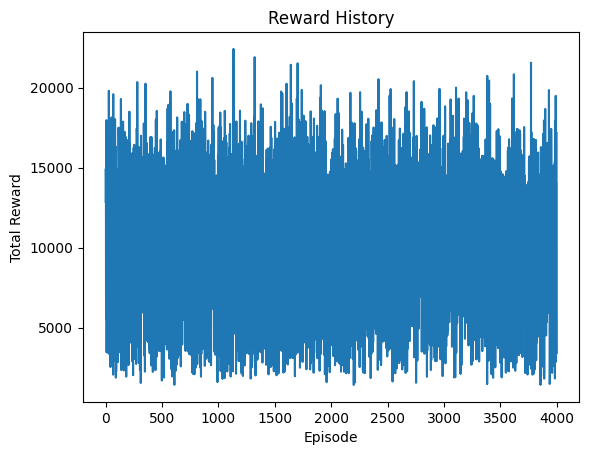

In [ ]:
#plot rewards
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward History')
plt.show()

### test Q-agent

In [ ]:
#test
env = RCMazeEnv()

env.init_pygame()

# Example of running the environment
agent.test(env)


env.close_pygame()

Test Total Reward: 11763.933972613984


In [ ]:
env.close_pygame()

### conclusions

After testing it is clear that it is able to solve the enivronment. But not at all efficient, the car gets stuck multiple times and will take go backwards often. (This is probably caused by the over engineered reward function.)

## DQN

### environment

In [ ]:
import numpy as np

import gym
from gym import spaces

import pygame

class RCMazeEnv(gym.Env):
    def __init__(self, maze_size_x=12, maze_size_y=12):
        self.maze_size_x = maze_size_x
        self.maze_size_y = maze_size_y
        self.maze = self.generate_maze()
        self.car_position = (1, 1)
        self.possible_actions = range(3)
        self.car_orientation = 'N'
        self.sensor_readings = {'front': 0, 'left': 0, 'right': 0}
        self.steps = 0
        self.previous_distance = 0
        self.goal = (10, 10)
        self.previous_steps = 0
        self.visited_positions = set()
        self.reset()

            
    def generate_maze(self):
        # For simplicity, create a static maze with walls
        # '1' represents a wall, and '0' represents an open path
        maze = np.zeros((self.maze_size_y, self.maze_size_x), dtype=int)
        # Add walls to the maze (this can be customized)

        
        layout = [
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
            [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
            [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1],
            [1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1],
            [1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1],
            [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
        
     
        maze = np.array(layout)

        return maze

    def reset(self):
        self.car_position = (1, 1)
        self.car_orientation = 'N'
        self.update_sensor_readings()
        self.steps = 0
        self.previous_distance = 0
        self.previous_steps = 0
        self.visited_positions.clear()  # Clear the visited positions
        self.visited_positions.add(self.car_position)
        return self.get_state()

    def step(self, action):
        if action == 0:
            self.move_forward()
        elif action == 1:
            self.turn_left()
        elif action == 2:
            self.turn_right()
        self.update_sensor_readings()
        self.visited_positions.add(self.car_position)
        reward = self.compute_reward()
        self.steps += 1
        done = self.is_done()
        return self.get_state(), reward, done

    
    def move_forward(self):
        x, y = self.car_position
        if self.car_orientation == 'N' and y > 0 and self.maze[y - 1][x] != 1:
            self.car_position = (x, y - 1)
        elif self.car_orientation == 'S' and y < self.maze_size_y - 1 and self.maze[y + 1][x] != 1:
            self.car_position = (x, y + 1)
        elif self.car_orientation == 'E' and x < self.maze_size_x - 1 and self.maze[y][x + 1] != 1:
            self.car_position = (x + 1, y)
        elif self.car_orientation == 'W' and x > 0 and self.maze[y][x - 1] != 1:
            self.car_position = (x - 1, y)
        

    def turn_left(self):
        orientations = ['N', 'W', 'S', 'E']
        idx = orientations.index(self.car_orientation)
        self.car_orientation = orientations[(idx + 1) % 4]

    def turn_right(self):
        orientations = ['N', 'E', 'S', 'W']
        idx = orientations.index(self.car_orientation)
        self.car_orientation = orientations[(idx + 1) % 4]

    def update_sensor_readings(self):
        # Simple sensor implementation: counts steps to the nearest wall
        self.sensor_readings['front'] = self.distance_to_wall('front')
        self.sensor_readings['left'] = self.distance_to_wall('left')
        self.sensor_readings['right'] = self.distance_to_wall('right')

    def distance_to_wall(self, direction):
        x, y = self.car_position
        distance = 0
        max_distance = self.maze_size_x if direction in ['left', 'right'] else self.maze_size_y

        
        if direction == 'front':
            if self.car_orientation == 'N':
                while y - distance >= 0 and self.maze[y - distance][x] != 1:
                    distance += 1
            elif self.car_orientation == 'S':
                while y + distance < self.maze_size_y and self.maze[y + distance][x] != 1:
                    distance += 1
            elif self.car_orientation == 'E':
                while x + distance < self.maze_size_x and self.maze[y][x + distance] != 1:
                    distance += 1
            elif self.car_orientation == 'W':
                while x - distance >= 0 and self.maze[y][x - distance] != 1:
                    distance += 1
        elif direction == 'left':
            if self.car_orientation == 'N':
                while x - distance >= 0 and self.maze[y][x - distance] != 1:
                    distance += 1
            elif self.car_orientation == 'S':
                while x + distance < self.maze_size_x and self.maze[y][x + distance] != 1:
                    distance += 1
            elif self.car_orientation == 'E':
                while y - distance >= 0 and self.maze[y - distance][x] != 1:
                    distance += 1
            elif self.car_orientation == 'W':
                while y + distance < self.maze_size_y and self.maze[y + distance][x] != 1:
                    distance += 1
        elif direction == 'right':
            if self.car_orientation == 'N':
                while x + distance < self.maze_size_x and self.maze[y][x + distance] != 1:
                    distance += 1
            elif self.car_orientation == 'S':
                while x - distance >= 0 and self.maze[y][x - distance] != 1:
                    distance += 1
            elif self.car_orientation == 'E':
                while y + distance < self.maze_size_y and self.maze[y + distance][x] != 1:
                    distance += 1
            elif self.car_orientation == 'W':
                while y - distance >= 0 and self.maze[y - distance][x] != 1:
                    distance += 1
        
            # Normalize the measured distance
        normalized_distance = (max_distance - distance - 1) / (max_distance - 1)

        # Ensure the value is within the range [0, 1]
        normalized_distance = max(0, min(normalized_distance, 1))

        return normalized_distance
    
    def compute_reward(self):
        # Initialize reward
        reward = 0

        # Check for collision or out of bounds
        if any(self.sensor_readings[direction] == 0 for direction in ['front', 'left', 'right']):
            reward -= 20

        # Check if goal is reached
        if self.car_position == self.goal:
            reward += 500
            # Additional penalty if it takes too many steps to reach the goal
            if self.steps > 1000:
                reward -= 200
            return reward  # Return immediately as this is the terminal state

        # Calculate the Euclidean distance to the goal
        distance_to_goal = ((self.car_position[0] - self.goal[0]) ** 2 + (self.car_position[1] - self.goal[1]) ** 2) ** 0.5

        # Define a maximum reward when the car is at the goal
        max_reward_at_goal = 50

        # Reward based on proximity to the goal
        reward += max_reward_at_goal / (distance_to_goal + 1)  # Adding 1 to avoid division by zero

        # # Reward or penalize based on movement towards or away from the goal
        if distance_to_goal < self.previous_distance:
            reward += 50  # Positive reward for moving closer to the goal
        elif distance_to_goal > self.previous_distance:
            reward -= 25  # Negative reward for moving farther from the goal

        if self.car_position in self.visited_positions:
            # Apply a penalty for revisiting the same position
            reward -= 10
            
        # Penalize for each step taken to encourage efficiency
        reward -= 2
        
        # Update the previous_distance for the next step
        self.previous_distance = distance_to_goal
        return reward


        

    def is_done(self):
        #is done if it reaches the goal or goes out of bounds or takes more than 3000 steps
        return self.car_position == self.goal or self.steps > 3000 or self.car_position[0] < 0 or self.car_position[1] < 0 or self.car_position[0] > 11 or self.car_position[1] > 11
        
        
        
    def get_state(self):
        car_position = [float(coord) for coord in self.car_position]
        sensor_readings = [float(value) for value in self.sensor_readings.values()]
        
        state = car_position + [self.car_orientation] + sensor_readings
        
        # cast state to this ['1.0' '1.0' 'N' '1.0' '1.0' '10.0']
        state = np.array(state, dtype=str)
        
        #get the orientation and convert do label encoding
        if state[2] == 'N':
            state[2] = 0
        elif state[2] == 'E':
            state[2] = 1
        elif state[2] == 'S':
            state[2] = 2
        elif state[2] == 'W':
            state[2] = 3
            
        state = np.array(state, dtype=float)
        
        return state

    
    def init_pygame(self):
        # Initialize Pygame and set up the display
        pygame.init()
        self.cell_size = 40  # Size of each cell in pixels
        self.maze_size_x = 12  # Assuming the maze size_x is 12
        self.maze_size_y = 12  # Assuming the maze size_y is 12
        self.width = 600
        self.height = 600
        self.screen = pygame.display.set_mode((self.width, self.height))
        self.clock = pygame.time.Clock()

    def render(self, framerate=60, delay=0):
        # Render the environment using Pygame
        for y in range(self.maze_size_y):
            for x in range(self.maze_size_x):
                rect = pygame.Rect(x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size)
                if (x, y) == self.goal:  # Goal position
                    color = (0, 255, 0)  # Green color for the goal
                elif self.maze[y][x] == 0:
                    color = (255, 255, 255)  # White color for empty space
                else:
                    color = (0, 0, 0)  # Black color for walls
                pygame.draw.rect(self.screen, color, rect)
        
        # Draw the car
        car_x, car_y = self.car_position
        car_rect = pygame.Rect(car_x * self.cell_size, car_y * self.cell_size, self.cell_size, self.cell_size)
        pygame.draw.rect(self.screen, (255, 0, 0), car_rect)  # Red color for the car
        pygame.time.delay(delay)
        pygame.display.flip()
        self.clock.tick(framerate)  # Limit the frame rate to 60 FPS


    def close_pygame(self):
        # Close the Pygame window
        pygame.quit()

In [ ]:
from tensorflow.keras.optimizers.legacy import Adam
class DQAgent:
    def __init__(self, replayCapacity, input_shape, output_shape):
        ## Initialize replay memory
        self.capacity = replayCapacity
        self.memory = collections.deque(maxlen=self.capacity)
        self.populated = False
        ## Policiy model
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.policy_model = self.buildNetwork()

        ## Target model
        self.target_model = self.buildNetwork()
        self.target_model.set_weights(self.policy_model.get_weights())

    def addToReplayMemory(self, step):
        self.step = step
        self.memory.append(self.step)

    def sampleFromReplayMemory(self, batchSize):
        self.batchSize = batchSize
        if self.batchSize > len(self.memory):
            self.populated = False
            return self.populated
        else:
            return random.sample(self.memory, self.batchSize)


    def buildNetwork(self):
        model = Sequential()
        model.add(Dense(32, input_shape=self.input_shape, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(self.output_shape, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['MeanSquaredError'])
        return model

    def policy_network_fit(self,batch, batchSize):
        self.batchSize = batchSize
        self.batch = batch


    def policy_network_predict(self, state):
        self.state = state
        self.qPolicy = self.policy_model.predict(self.state)
        return self.qPolicy

    def target_network_predict(self, state):
        self.state = state
        self.qTarget = self.target_model.predict(self.state)
        return self.qTarget

    def update_target_network(self):
        self.target_model.set_weights(self.policy_model.get_weights())

In [ ]:
env = RCMazeEnv()
state = env.reset()

env.init_pygame()

# Model parameters
REPLAY_MEMORY_CAPACITY = 20000
# MIN_REPLAY_MEMORY_SIZE = 1_000  # Minimum number of steps in a memory to start training
POSSIBLE_ACTIONS = env.possible_actions

# state = state[0]
# create DQN agent
agent = DQAgent(replayCapacity=REPLAY_MEMORY_CAPACITY, input_shape=state.shape, output_shape=len(POSSIBLE_ACTIONS))


# reset the parameters
DISCOUNT = 0.90
BATCH_SIZE = 64  # How many steps (samples) to use for training
UPDATE_TARGET_INTERVAL = 500
EPSILON = 0.99 # Exploration percentage
MIN_EPSILON = 0.01
DECAY = 0.9999
EPISODE_AMOUNT = 170

# Fill the replay memory with the first batch of samples
update_counter = 0
reward_history = []
epsilon_history = []

np.set_printoptions(precision=3, suppress=True)

for episode in range(EPISODE_AMOUNT):
    episode_reward = 0
    step_counter = 0  # count the number of successful steps within the episode

    state = env.reset()
    done = False
    epsilon_history.append(EPSILON)

    while not done:
        env.render(delay=0, framerate=240)

        if random.random() <= EPSILON:
            action = random.sample(POSSIBLE_ACTIONS, 1)[0]
        else:
            qValues = agent.policy_network_predict(state.reshape(1,-1))
            action = np.argmax(qValues[0])

        new_state, reward, done = env.step(action)

        step_counter +=1

        # store step in replay memory
        step = (state, action, reward, new_state, done)
        agent.addToReplayMemory(step)
        state = new_state
        episode_reward += reward
        # When enough steps in replay memory -> train policy network
        if len(agent.memory) >= REPLAY_MEMORY_CAPACITY / 2:
            EPSILON = DECAY * EPSILON
            if EPSILON < MIN_EPSILON:
                EPSILON = MIN_EPSILON
            # sample minibatch from replay memory
            
            miniBatch = agent.sampleFromReplayMemory(BATCH_SIZE)
            miniBatch_states = np.asarray(list(zip(*miniBatch))[0],dtype=float)
            miniBatch_actions = np.asarray(list(zip(*miniBatch))[1], dtype = int)
            miniBatch_rewards = np.asarray(list(zip(*miniBatch))[2], dtype = float)
            miniBatch_next_state = np.asarray(list(zip(*miniBatch))[3],dtype=float)
            miniBatch_done = np.asarray(list(zip(*miniBatch))[4],dtype=bool)
            
            # current state q values1tch_states)
            y = agent.policy_network_predict(miniBatch_states)

            next_state_q_values = agent.target_network_predict(miniBatch_next_state)
            max_q_next_state = np.max(next_state_q_values,axis=1)

            for i in range(BATCH_SIZE):
                if miniBatch_done[i]:
                    y[i,miniBatch_actions[i]] = miniBatch_rewards[i]
                else:
                    y[i,miniBatch_actions[i]] = miniBatch_rewards[i] + DISCOUNT *  max_q_next_state[i]

            agent.policy_model.fit(miniBatch_states, y, batch_size=BATCH_SIZE, verbose = 0)
            
            #todo: add early stopping
        else:
            continue
        if update_counter == UPDATE_TARGET_INTERVAL:
            agent.update_target_network()
            update_counter = 0
        update_counter += 1
    print('episode_Reward for episode ', episode, '= ', episode_reward, 'with epsilon = ', EPSILON)
    env.render(delay=0, framerate=360)
    reward_history.append(episode_reward)
env.close_pygame()
env.close()

2024-01-08 14:41:22.102944: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-08 14:41:22.103024: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-08 14:41:22.103062: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

episodeReward for episode  0 =  -10677.882850145981 with epsilon =  0.7379604645900195
episodeReward for episode  1 =  -6827.366045601178 with epsilon =  0.572365370057636
episodeReward for episode  2 =  -3433.734233482003 with epsilon =  0.502839518693804
episodeReward for episode  3 =  -6274.6079569346075 with epsilon =  0.4286167167112175
episodeReward for episode  4 =  -104.1527400685603 with epsilon =  0.3174905580095042
episodeReward for episode  5 =  1589.4126720939103 with epsilon =  0.27408567194474975
episodeReward for episode  6 =  1544.0527588010327 with epsilon =  0.26336442875853483
episodeReward for episode  7 =  2819.7546297379754 with epsilon =  0.24607474678234964
episodeReward for episode  8 =  805.9716320339489 with epsilon =  0.20795608402776736
episodeReward for episode  9 =  1283.628155753056 with epsilon =  0.20646410319913977
episodeReward for episode  10 =  1276.5667043008866 with epsilon =  0.2053521464285686
episodeReward for episode  11 =  1297.836137637563

In [ ]:
env.close_pygame()

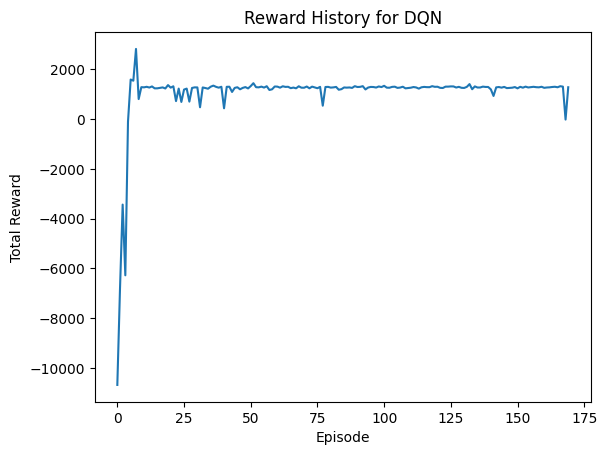

In [ ]:
#plot rewards
plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward History for DQN')
plt.show()



In [ ]:
#save model
agent.policy_model.save('./models/DQN_RCmaze_v2.h5')

/home/lucasdriessens/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### test

In [ ]:
# try it out
# load model
env = RCMazeEnv()
state = env.reset()

env.init_pygame()

REPLAY_MEMORY_CAPACITY = 20000
POSSIBLE_ACTIONS = env.possible_actions

# create DQN agent
test_agent = DQAgent(replayCapacity=REPLAY_MEMORY_CAPACITY, input_shape=state.shape, output_shape=len(POSSIBLE_ACTIONS))


from keras.models import load_model
test_agent.policy_model = load_model('./models/DQN_RCmaze_v2.h5')


done = False

rewards = []

while not done:
    env.render(delay=100, framerate=60)
   
    qValues = test_agent.policy_network_predict(np.array([state]))
    action = np.argmax(qValues[0])
    state, reward, done = env.step(action)
    rewards.append(reward)
    
    env.render()
    if done:
        print('done in ', len(rewards), 'steps')
        break
env.close()
print(sum(rewards))
env.close_pygame()


2024-01-08 12:47:26.144459: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_29/kernel/Assign' id:1776 op device:{requested: '', assigned: ''} def:{{{node dense_29/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_29/kernel, dense_29/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-08 12:47:26.260517: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_52_1/bias/Assign' id:1951 op device:{requested: '', assigned: ''} def:{{{node dense_52_1/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_52_1/bias, dense_52_1/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, an

done in  34 steps
1296.992428778307


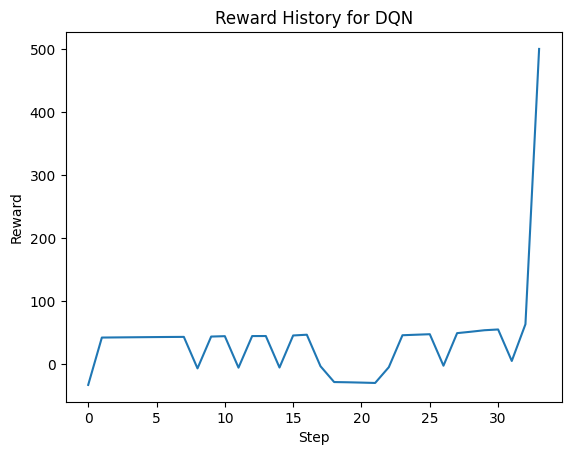

In [ ]:
#plot rewards and distance to goal
plt.plot(rewards)
plt.xlabel('Step')
plt.ylabel('Reward')
plt.title('Reward History for DQN')
plt.show()



### conclusions

The DQN is able to solve the environment in 34 steps, which is a great improvement over the Q-agent. The car now goes straight to the goal, so this is something I can work with.

# 3d env

In [ ]:
import numpy as np

import gym
from gym import spaces

from OpenGL.GL import *
from OpenGL.GLUT import *
from OpenGL.GLU import *

import pygame

import random
import matplotlib.pyplot as plt
import collections



In [ ]:
class RCMazeEnv(gym.Env):
   def __init__(self, maze_size_x=12, maze_size_y=12):
      self.maze_size_x = maze_size_x
      self.maze_size_y = maze_size_y
      self.maze = self.generate_maze()
      self.car_position = (1, 1)
      self.possible_actions = range(3)
      self.car_orientation = 'N'
      self.sensor_readings = {'front': 0, 'left': 0, 'right': 0}
      self.steps = 0
      self.previous_distance = 0
      self.goal = (10, 10)
      self.previous_steps = 0
      self.visited_positions = set()
      self.reset()

         
   def generate_maze(self):
      # For simplicity, create a static maze with walls
      # '1' represents a wall, and '0' represents an open path
      maze = np.zeros((self.maze_size_y, self.maze_size_x), dtype=int)
      # Add walls to the maze (this can be customized)

      
      layout = [
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
         [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
         [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1],
         [1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1],
         [1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1],
         [1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1],
         [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1],
         [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
      
   
      maze = np.array(layout)

      return maze

   def reset(self):
      self.car_position = (1, 1)
      self.car_orientation = 'N'
      self.update_sensor_readings()
      self.steps = 0
      self.previous_distance = 0
      self.previous_steps = 0
      self.visited_positions.clear()  # Clear the visited positions
      self.visited_positions.add(self.car_position)
      return self.get_state()

   def step(self, action):
      if action == 0:
         self.move_forward()
      elif action == 1:
         self.turn_left()
      elif action == 2:
         self.turn_right()
      self.update_sensor_readings()
      self.visited_positions.add(self.car_position)
      reward = self.compute_reward()
      self.steps += 1
      done = self.is_done()
      return self.get_state(), reward, done

   
   def move_forward(self):
      x, y = self.car_position
      if self.car_orientation == 'N' and y > 0 and self.maze[y - 1][x] != 1:
         self.car_position = (x, y - 1)
      elif self.car_orientation == 'S' and y < self.maze_size_y - 1 and self.maze[y + 1][x] != 1:
         self.car_position = (x, y + 1)
      elif self.car_orientation == 'E' and x < self.maze_size_x - 1 and self.maze[y][x + 1] != 1:
         self.car_position = (x + 1, y)
      elif self.car_orientation == 'W' and x > 0 and self.maze[y][x - 1] != 1:
         self.car_position = (x - 1, y)
      

   def turn_left(self):
      orientations = ['N', 'W', 'S', 'E']
      idx = orientations.index(self.car_orientation)
      self.car_orientation = orientations[(idx + 1) % 4]

   def turn_right(self):
      orientations = ['N', 'E', 'S', 'W']
      idx = orientations.index(self.car_orientation)
      self.car_orientation = orientations[(idx + 1) % 4]

   def update_sensor_readings(self):
      # Simple sensor implementation: counts steps to the nearest wall
      self.sensor_readings['front'] = self.distance_to_wall('front')
      self.sensor_readings['left'] = self.distance_to_wall('left')
      self.sensor_readings['right'] = self.distance_to_wall('right')

   def distance_to_wall(self, direction):
      x, y = self.car_position
      distance = 0
      max_distance = self.maze_size_x if direction in ['left', 'right'] else self.maze_size_y
      
      if direction == 'front':
         if self.car_orientation == 'N':
               while y - distance >= 0 and self.maze[y - distance][x] != 1:
                  distance += 1
         elif self.car_orientation == 'S':
               while y + distance < self.maze_size_y and self.maze[y + distance][x] != 1:
                  distance += 1
         elif self.car_orientation == 'E':
               while x + distance < self.maze_size_x and self.maze[y][x + distance] != 1:     
                  distance += 1
         elif self.car_orientation == 'W':
               while x - distance >= 0 and self.maze[y][x - distance] != 1:
                  distance += 1
      elif direction == 'left':
         if self.car_orientation == 'N':
               while x - distance >= 0 and self.maze[y][x - distance] != 1:
                  distance += 1
         elif self.car_orientation == 'S':
               while x + distance < self.maze_size_x and self.maze[y][x + distance] != 1:
                  distance += 1
         elif self.car_orientation == 'E':
               while y - distance >= 0 and self.maze[y - distance][x] != 1:
                  distance += 1
         elif self.car_orientation == 'W':
               while y + distance < self.maze_size_y and self.maze[y + distance][x] != 1:
                  distance += 1
      elif direction == 'right':
         if self.car_orientation == 'N':
               while x + distance < self.maze_size_x and self.maze[y][x + distance] != 1:
                  distance += 1
         elif self.car_orientation == 'S':
               while x - distance >= 0 and self.maze[y][x - distance] != 1:
                  distance += 1
         elif self.car_orientation == 'E':
               while y + distance < self.maze_size_y and self.maze[y + distance][x] != 1:
                  distance += 1
         elif self.car_orientation == 'W':
               while y - distance >= 0 and self.maze[y - distance][x] != 1:
                  distance += 1
      
         # Normalize the measured distance
      normalized_distance = (max_distance - distance - 1) / (max_distance - 1)

      # Ensure the value is within the range [0, 1]
      normalized_distance = max(0, min(normalized_distance, 1))

      return normalized_distance
   
   def compute_reward(self):
      # Initialize reward
      reward = 0

      # Check for collision or out of bounds
      if any(self.sensor_readings[direction] == 0 for direction in ['front', 'left', 'right']):
         reward -= 20

      # Check if goal is reached
      if self.car_position == self.goal:
         reward += 500
         # Additional penalty if it takes too many steps to reach the goal
         if self.steps > 1000:
               reward -= 200
         return reward  # Return immediately as this is the terminal state

      # Calculate the Euclidean distance to the goal
      distance_to_goal = ((self.car_position[0] - self.goal[0]) ** 2 + (self.car_position[1] - self.goal[1]) ** 2) ** 0.5

      # Define a maximum reward when the car is at the goal
      max_reward_at_goal = 50

      # Reward based on proximity to the goal
      reward += max_reward_at_goal / (distance_to_goal + 1)  # Adding 1 to avoid division by zero

      # # Reward or penalize based on movement towards or away from the goal
      if distance_to_goal < self.previous_distance:
         reward += 50  # Positive reward for moving closer to the goal
      elif distance_to_goal > self.previous_distance:
         reward -= 25  # Negative reward for moving farther from the goal

      if self.car_position in self.visited_positions:
         # Apply a penalty for revisiting the same position
         reward -= 10
         
      # Penalize for each step taken to encourage efficiency
      reward -= 2
      
      # Update the previous_distance for the next step
      self.previous_distance = distance_to_goal
      return reward

   def is_done(self):
      #is done if it reaches the goal or goes out of bounds or takes more than 3000 steps
      return self.car_position == self.goal or self.steps > 3000 or self.car_position[0] < 0 or self.car_position[1] < 0 or self.car_position[0] > 11 or self.car_position[1] > 11
      
   def get_state(self):
      car_position = [float(coord) for coord in self.car_position]
      sensor_readings = [float(value) for value in self.sensor_readings.values()]
      
      state = car_position + [self.car_orientation] + sensor_readings
      
      # cast state to this ['1.0' '1.0' 'N' '1.0' '1.0' '10.0']
      state = np.array(state, dtype=str)
      
      #get the orientation and convert do label encoding
      if state[2] == 'N':
         state[2] = 0
      elif state[2] == 'E':
         state[2] = 1
      elif state[2] == 'S':
         state[2] = 2
      elif state[2] == 'W':
         state[2] = 3
         
      state = np.array(state, dtype=float)
      
      return state

   def init_opengl(self):
      # Initialize OpenGL context
      glutInit()
      glutInitDisplayMode(GLUT_RGBA | GLUT_DOUBLE | GLUT_DEPTH)
      glutInitWindowSize(1200, 1200)
      glutCreateWindow("RC Maze Environment")

      # Set up OpenGL environment
      glEnable(GL_DEPTH_TEST)
      glClearColor(0.0, 0.0, 0.0, 0.0)  # Clear to a grey color

      # Set up lighting (optional)
      glEnable(GL_LIGHTING)
      glEnable(GL_LIGHT0)
      glLightfv(GL_LIGHT0, GL_POSITION, [0, 10, 10, 1])
      glLightfv(GL_LIGHT0, GL_AMBIENT, [0.1, 0.1, 0.1, 1])
      glLightfv(GL_LIGHT0, GL_DIFFUSE, [1, 1, 1, 1])
      
      glColorMaterial(GL_FRONT_AND_BACK, GL_AMBIENT_AND_DIFFUSE)
      glEnable(GL_COLOR_MATERIAL)

      # Set up camera (you may want to make this adjustable)
      gluLookAt(self.maze_size_x / 2, self.maze_size_y / 2, 10,  # Camera position (above the center of the maze)
          self.maze_size_x / 2, self.maze_size_y / 2, 0,  # Look at point (center of the maze)
          0, 1, 0)  # Up vector
      
      glMatrixMode(GL_PROJECTION)
      glLoadIdentity()
      gluPerspective(90, 1, 0.1, 100)  # Adjust field of view angle, aspect ratio, near and far planes
      glMatrixMode(GL_MODELVIEW)
      glClear(GL_COLOR_BUFFER_BIT | GL_DEPTH_BUFFER_BIT)
      
      
      
      
        # Set the rendering function
      glutDisplayFunc(self.render)
      
   def run_opengl(self):
        # Set up the rendering context and callbacks
        # but do NOT call glutMainLoop()
        glutDisplayFunc(self.render)
        glutIdleFunc(self.render)  # Update rendering in idle time

   def render(self):
      # Clear buffers
      glClear(GL_COLOR_BUFFER_BIT | GL_DEPTH_BUFFER_BIT)
      camera_distance = 0.5 # Distance from the camera to the car
      camera_height = 1.5  # Height of the camera above the car
      
      # Assuming self.car_orientation is 'N' and you want to be behind the car (to the 'S')
      if self.car_orientation == 'N':  # Car is facing North
         camera_x = self.car_position[0]
         camera_y = (self.maze_size_y - self.car_position[1] - 1) - camera_distance  # Move camera to South
         camera_z = camera_height
      elif self.car_orientation == 'S':  # Car is facing South
         camera_x = self.car_position[0]
         camera_y = (self.maze_size_y - self.car_position[1] - 1) + camera_distance  # Move camera to North
         camera_z = camera_height
      elif self.car_orientation == 'E':  # Car is facing East
         camera_x = self.car_position[0] - camera_distance  # Move camera to West
         camera_y = self.maze_size_y - self.car_position[1] - 1
         camera_z = camera_height
      elif self.car_orientation == 'W':  # Car is facing West
         camera_x = self.car_position[0] + camera_distance  # Move camera to East
         camera_y = self.maze_size_y - self.car_position[1] - 1
         camera_z = camera_height

      # The point where the camera should be pointed: the car's position
      look_at_x = self.car_position[0]
      look_at_y = self.maze_size_y - self.car_position[1] - 1
      look_at_z = 1  # Assuming the car is at ground level (z=0)

      # Set up the camera
      glMatrixMode(GL_MODELVIEW)
      glLoadIdentity()
      gluLookAt(camera_x, camera_y, camera_z,  # Camera position (x, y, z)
               look_at_x, look_at_y, look_at_z,  # Look at position (x, y, z)
               0, 0, 2)  # Up vector (x, y, z), assuming Z is up

      # Render the maze
      for y in range(self.maze_size_y):
         for x in range(self.maze_size_x):
               if self.maze[y][x] == 1:
                  self.draw_cube(x, y, color=(0.5, 0.5, 0.5))
               elif (x, y) == self.goal:
                  #set color to green
                  self.draw_cube(x, y, color=(0.0, 1.0, 0.0))
                  
      # Render the car's sensor readings
      car_x, car_y = self.car_position
      #set sensor_color_directon with front being light blue, left being yellow and right being green
      sensor_colors = {'front': (0.0, 1.0, 1.0), 'left': (1.0, 1.0, 0.0), 'right': (0.0, 1.0, 0.0)}
      
      # Render the sensors
      for sensor in ['front', 'left', 'right']:
         self.draw_sensor_line(car_x, car_y, self.sensor_readings[sensor], 
                                 sensor_colors[sensor], sensor)
         
      # Draw the car
      car_x, car_y = self.car_position
      self.draw_car(car_x, car_y, color=(1.0, 0.0, 0.0))
      
      # Swap buffers
      glutSwapBuffers()
      

   def draw_cube(self, x, y, color):
      # Set the color
      glColor3fv(color)

      # Draw a cube at position (x, y), flipping y coordinate
      glPushMatrix()
      glTranslate(x, self.maze_size_y - y - 1, 0)  # Adjust for vertical flipping
      glScalef(2, 2, 5)  # Adjust the size of your cube
      glutSolidCube(0.5)  # Adjust the size if needed
      glPopMatrix()
      
   def get_sensor_rotation_angle(self, sensor_orientation):
      print('direction: ', self.car_orientation)
      # Rotation logic based on car's orientation and sensor's relative position
      rotation_mapping = {
         'N': {'front': 0, 'left': 90, 'right': -90},
         'S': {'front': -90, 'left': 0, 'right': 180},
         'E': {'front': 0, 'left': 90, 'right': -90},
         'W': {'front': 180, 'left': -90, 'right': 90}
      }


      # Calculate total rotation angle
      return rotation_mapping[self.car_orientation][sensor_orientation]

   def draw_sensor_line(self, car_x, car_y, distance, color, sensor_orientation):
      close_threshold = 0.5
      glColor3fv((1.0, 0.0, 0.0) if distance <= close_threshold else color)

      # Calculate rotation based on car's and sensor's orientation
      rotation_angle = self.get_sensor_rotation_angle(sensor_orientation)

      glPushMatrix()
      glTranslate(car_x, self.maze_size_y - car_y - 1, 0.5)  # Adjust for vertical flipping
      glRotatef(rotation_angle, 0, 0, 1)
      glRotatef(90, 0, 1, 0)

      # Draw sensor line
      distance = min(distance, 0.5)  # Cap distance
      glutSolidCylinder(0.05, distance, 5, 5)

      glPopMatrix()

   def draw_car(self, x, y, color):
      # Set the color
      glColor3fv(color)

      # Draw a cube at position (x, y), flipping y coordinate
      glPushMatrix()
      glTranslate(x, self.maze_size_y - y - 1, 0)  # Adjust for vertical flipping
      glScalef(1, 1, 1)  # Adjust the size of your cube
      glutSolidCube(0.5)  # Adjust the size if needed
      glPopMatrix()

   def close_opengl(self):
      # Close the OpenGL context
      glutLeaveMainLoop()


In [ ]:
class DQNAgent:
    def __init__(self, replayCapacity, input_shape, output_shape):
        ## Initialize replay memory
        self.capacity = replayCapacity
        self.memory = collections.deque(maxlen=self.capacity)
        self.populated = False
        ## Policiy model
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.policy_model = self.buildNetwork()

        ## Target model
        self.target_model = self.buildNetwork()
        self.target_model.set_weights(self.policy_model.get_weights())

    def addToReplayMemory(self, step):
        self.step = step
        self.memory.append(self.step)

    def sampleFromReplayMemory(self, batchSize):
        self.batchSize = batchSize
        if self.batchSize > len(self.memory):
            self.populated = False
            return self.populated
        else:
            return random.sample(self.memory, self.batchSize)


    def buildNetwork(self):
        model = Sequential()
        model.add(Dense(32, input_shape=self.input_shape, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(self.output_shape, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['MeanSquaredError'])
        return model

    def policy_network_fit(self,batch, batchSize):
        self.batchSize = batchSize
        self.batch = batch


    def policy_network_predict(self, state):
        self.state = state
        self.qPolicy = self.policy_model.predict(self.state)
        return self.qPolicy

    def target_network_predict(self, state):
        self.state = state
        self.qTarget = self.target_model.predict(self.state)
        return self.qTarget

    def update_target_network(self):
        self.target_model.set_weights(self.policy_model.get_weights()) 


In [ ]:
import time
env = RCMazeEnv()
state = env.reset()

env.init_opengl()
env.run_opengl()

REPLAY_MEMORY_CAPACITY = 20000
POSSIBLE_ACTIONS = env.possible_actions

# create DQN agent
test_agent = DQNAgent(replayCapacity=REPLAY_MEMORY_CAPACITY, input_shape=state.shape, output_shape=len(POSSIBLE_ACTIONS))


from keras.models import load_model
test_agent.policy_model = load_model('./models/DQN_RCmaze_v2.h5')

done = False
rewards = []

desired_fps = 5.0
frame_duration = 1.0 / desired_fps

last_time = time.time()
done = False


while not done:
   current_time = time.time()
   elapsed = current_time - last_time
   if elapsed >= frame_duration:
      
      glutMainLoopEvent()
      qValues = test_agent.policy_network_predict(np.array([state]))
      action = np.argmax(qValues[0])
      state, reward, done = env.step(action)
      rewards.append(reward)
      env.render()
      
      last_time = current_time
      
      if done:
         print('done in ', len(rewards), 'steps')
         break
# env.close()
print(sum(rewards))

# Double DQN

In [ ]:
import numpy as np

import gym
from gym import spaces

import pygame

class RCMazeEnv(gym.Env):
    def __init__(self, maze_size_x=12, maze_size_y=12):
        self.maze_size_x = maze_size_x
        self.maze_size_y = maze_size_y
        self.maze = self.generate_maze()
        self.car_position = (1, 1)
        self.possible_actions = range(3)
        self.car_orientation = 'N'
        self.sensor_readings = {'front': 0, 'left': 0, 'right': 0}
        self.steps = 0
        self.previous_distance = 0
        self.goal = (10, 10)
        self.previous_steps = 0
        self.visited_positions = set()
        self.reset()

            
    def generate_maze(self):
        # For simplicity, create a static maze with walls
        # '1' represents a wall, and '0' represents an open path
        maze = np.zeros((self.maze_size_y, self.maze_size_x), dtype=int)
        # Add walls to the maze (this can be customized)

        
        layout = [
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
            [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
            [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1],
            [1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1],
            [1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1],
            [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
        
     
        maze = np.array(layout)

        return maze

    def reset(self):
        self.car_position = (1, 1)
        self.car_orientation = 'N'
        self.update_sensor_readings()
        self.steps = 0
        self.previous_distance = 0
        self.previous_steps = 0
        self.visited_positions.clear()  # Clear the visited positions
        self.visited_positions.add(self.car_position)
        return self.get_state()

    def step(self, action):
        if action == 0:
            self.move_forward()
        elif action == 1:
            self.turn_left()
        elif action == 2:
            self.turn_right()
        self.update_sensor_readings()
        self.visited_positions.add(self.car_position)
        reward = self.compute_reward()
        self.steps += 1
        done = self.is_done()
        return self.get_state(), reward, done

    
    def move_forward(self):
        x, y = self.car_position
        if self.car_orientation == 'N' and y > 0 and self.maze[y - 1][x] != 1:
            self.car_position = (x, y - 1)
        elif self.car_orientation == 'S' and y < self.maze_size_y - 1 and self.maze[y + 1][x] != 1:
            self.car_position = (x, y + 1)
        elif self.car_orientation == 'E' and x < self.maze_size_x - 1 and self.maze[y][x + 1] != 1:
            self.car_position = (x + 1, y)
        elif self.car_orientation == 'W' and x > 0 and self.maze[y][x - 1] != 1:
            self.car_position = (x - 1, y)
        

    def turn_left(self):
        orientations = ['N', 'W', 'S', 'E']
        idx = orientations.index(self.car_orientation)
        self.car_orientation = orientations[(idx + 1) % 4]

    def turn_right(self):
        orientations = ['N', 'E', 'S', 'W']
        idx = orientations.index(self.car_orientation)
        self.car_orientation = orientations[(idx + 1) % 4]

    def update_sensor_readings(self):
        # Simple sensor implementation: counts steps to the nearest wall
        self.sensor_readings['front'] = self.distance_to_wall('front')
        self.sensor_readings['left'] = self.distance_to_wall('left')
        self.sensor_readings['right'] = self.distance_to_wall('right')

    def distance_to_wall(self, direction):
        x, y = self.car_position
        sensor_max_range = 255  # Maximum range of the ultrasonic sensor

        def calculate_distance(dx, dy):
            distance = 0
            while 0 <= x + distance * dx < self.maze_size_x and \
                0 <= y + distance * dy < self.maze_size_y and \
                self.maze[y + distance * dy][x + distance * dx] != 1:
                distance += 1
                if distance > sensor_max_range:  # Limiting the sensor range
                    break
            return distance

        if direction == 'front':
            if self.car_orientation == 'N':
                distance = calculate_distance(0, -1)
            elif self.car_orientation == 'S':
                distance = calculate_distance(0, 1)
            elif self.car_orientation == 'E':
                distance = calculate_distance(1, 0)
            elif self.car_orientation == 'W':
                distance = calculate_distance(-1, 0)

        elif direction == 'left':
            if self.car_orientation == 'N':
                distance = calculate_distance(-1, 0)
            elif self.car_orientation == 'S':
                distance = calculate_distance(1, 0)
            elif self.car_orientation == 'E':
                distance = calculate_distance(0, -1)
            elif self.car_orientation == 'W':
                distance = calculate_distance(0, 1)

        elif direction == 'right':
            if self.car_orientation == 'N':
                distance = calculate_distance(1, 0)
            elif self.car_orientation == 'S':
                distance = calculate_distance(-1, 0)
            elif self.car_orientation == 'E':
                distance = calculate_distance(0, 1)
            elif self.car_orientation == 'W':
                distance = calculate_distance(0, -1)

        # Normalize the distance to a range of 0-1
        normalized_distance = distance / sensor_max_range
        normalized_distance = max(0, min(normalized_distance, 1))

        return normalized_distance
    
    def compute_reward(self):
        # Initialize reward
        reward = 0

        # Check for collision or out of bounds
        if any(self.sensor_readings[direction] == 0 for direction in ['front', 'left', 'right']):
            reward -= 20

        # Check if goal is reached
        if self.car_position == self.goal:
            reward += 500
            # Additional penalty if it takes too many steps to reach the goal
            if self.steps > 1000:
                reward -= 200
            return reward  # Return immediately as this is the terminal state

        # Calculate the Euclidean distance to the goal
        distance_to_goal = ((self.car_position[0] - self.goal[0]) ** 2 + (self.car_position[1] - self.goal[1]) ** 2) ** 0.5

        # Define a maximum reward when the car is at the goal
        max_reward_at_goal = 50

        # Reward based on proximity to the goal
        reward += max_reward_at_goal / (distance_to_goal + 1)  # Adding 1 to avoid division by zero

        # # Reward or penalize based on movement towards or away from the goal
        if distance_to_goal < self.previous_distance:
            reward += 50  # Positive reward for moving closer to the goal
        elif distance_to_goal > self.previous_distance:
            reward -= 25  # Negative reward for moving farther from the goal

        if self.car_position in self.visited_positions:
            # Apply a penalty for revisiting the same position
            reward -= 10
            
        # Penalize for each step taken to encourage efficiency
        reward -= 2
        
        # Update the previous_distance for the next step
        self.previous_distance = distance_to_goal
        return reward

    def is_done(self):
        #is done if it reaches the goal or goes out of bounds or takes more than 3000 steps
        return self.car_position == self.goal or self.steps > 3000 or self.car_position[0] < 0 or self.car_position[1] < 0 or self.car_position[0] > 11 or self.car_position[1] > 11
        
    def get_state(self):
        car_position = [float(coord) for coord in self.car_position]
        sensor_readings = [float(value) for value in self.sensor_readings.values()]
        
        state = car_position + [self.car_orientation] + sensor_readings
        
        # cast state to this ['1.0' '1.0' 'N' '1.0' '1.0' '10.0']
        state = np.array(state, dtype=str)
        
        #get the orientation and convert do label encoding
        if state[2] == 'N':
            state[2] = 0
        elif state[2] == 'E':
            state[2] = 1
        elif state[2] == 'S':
            state[2] = 2
        elif state[2] == 'W':
            state[2] = 3
            
        state = np.array(state, dtype=float)
        
        return state

    
    def init_pygame(self):
        # Initialize Pygame and set up the display
        pygame.init()
        self.cell_size = 40  # Size of each cell in pixels
        self.maze_size_x = 12  # Assuming the maze size_x is 12
        self.maze_size_y = 12  # Assuming the maze size_y is 12
        self.width = 600
        self.height = 600
        self.screen = pygame.display.set_mode((self.width, self.height))
        self.clock = pygame.time.Clock()

    def render(self, framerate=60, delay=0):
        # Render the environment using Pygame
        for y in range(self.maze_size_y):
            for x in range(self.maze_size_x):
                rect = pygame.Rect(x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size)
                if (x, y) == self.goal:  # Goal position
                    color = (0, 255, 0)  # Green color for the goal
                elif self.maze[y][x] == 0:
                    color = (255, 255, 255)  # White color for empty space
                else:
                    color = (0, 0, 0)  # Black color for walls
                pygame.draw.rect(self.screen, color, rect)
        
        # Draw the car
        car_x, car_y = self.car_position
        car_rect = pygame.Rect(car_x * self.cell_size, car_y * self.cell_size, self.cell_size, self.cell_size)
        pygame.draw.rect(self.screen, (255, 0, 0), car_rect)  # Red color for the car
        pygame.time.delay(delay)
        pygame.display.flip()
        self.clock.tick(framerate)  # Limit the frame rate to 60 FPS


    def close_pygame(self):
        # Close the Pygame window
        pygame.quit()

In [ ]:
from tensorflow.keras.optimizers.legacy import Adam
class DQAgent:
    def __init__(self, replayCapacity, input_shape, output_shape, learning_rate=0.001, discount_factor=0.90):
        self.capacity = replayCapacity
        self.memory = collections.deque(maxlen=self.capacity)
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.policy_model = self.buildNetwork()
        self.target_model = self.buildNetwork()
        self.target_model.set_weights(self.policy_model.get_weights())


    def addToReplayMemory(self, step):
        self.step = step
        self.memory.append(self.step)

    def sampleFromReplayMemory(self, batchSize):
        self.batchSize = batchSize
        if self.batchSize > len(self.memory):
            self.populated = False
            return self.populated
        else:
            return random.sample(self.memory, self.batchSize)


    def buildNetwork(self):
        model = Sequential()
        model.add(Dense(32, input_shape=self.input_shape, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(self.output_shape, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate), metrics=['MeanSquaredError'])
        return model

    def policy_network_fit(self, batch, batch_size):
            states, actions, rewards, next_states, dones = zip(*batch)

            states = np.array(states)
            next_states = np.array(next_states)

            # Predict Q-values for starting state using the policy network
            q_values = self.policy_model.predict(states)

            # Predict Q-values for next state using the policy network
            q_values_next_state_policy = self.policy_model.predict(next_states)

            # Select the best action for the next state using the policy network
            best_actions = np.argmax(q_values_next_state_policy, axis=1)

            # Predict Q-values for next state using the target network
            q_values_next_state_target = self.target_model.predict(next_states)

            # Update Q-values for actions taken
            for i in range(batch_size):
                if dones[i]:
                    q_values[i, actions[i]] = rewards[i]
                else:
                    # Double DQN update rule
                    q_values[i, actions[i]] = rewards[i] + self.discount_factor * q_values_next_state_target[i, best_actions[i]]

            # Train the policy network
            self.policy_model.fit(states, q_values, batch_size=batch_size, verbose=0)

    def policy_network_predict(self, state):
        self.state = state
        self.qPolicy = self.policy_model.predict(self.state)
        return self.qPolicy

    def target_network_predict(self, state):
        self.state = state
        self.qTarget = self.target_model.predict(self.state)
        return self.qTarget

    def update_target_network(self):
        self.target_model.set_weights(self.policy_model.get_weights())

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
env = RCMazeEnv()
state = env.reset()

env.init_pygame()

# Model parameters
REPLAY_MEMORY_CAPACITY = 20000
# MIN_REPLAY_MEMORY_SIZE = 1_000  # Minimum number of steps in a memory to start training
POSSIBLE_ACTIONS = env.possible_actions

# state = state[0]
# create DQN agent
agent = DQAgent(replayCapacity=REPLAY_MEMORY_CAPACITY, 
                input_shape=state.shape, 
                output_shape=len(POSSIBLE_ACTIONS),
                learning_rate=0.001, 
                discount_factor=0.90)


# reset the parameters
DISCOUNT = 0.90
BATCH_SIZE = 128  # How many steps (samples) to use for training
UPDATE_TARGET_INTERVAL = 5
EPSILON = 0.99 # Exploration percentage
MIN_EPSILON = 0.01
DECAY = 0.99993
EPISODE_AMOUNT = 170



# Fill the replay memory with the first batch of samples
update_counter = 0
reward_history = []
epsilon_history = []

np.set_printoptions(precision=3, suppress=True)

for episode in range(EPISODE_AMOUNT):
    episode_reward = 0
    step_counter = 0  # count the number of successful steps within the episode
    
    state = env.reset()
    done = False
    epsilon_history.append(EPSILON)
    
    # early stopping
    # if len(reward_history) > 10:
    #     last_10_rewards = reward_history[-10:]
    #     if all(reward > 0 for reward in last_10_rewards):
    #         differences = [abs(last_10_rewards[i] - last_10_rewards[i-1]) for i in range(1, 10)]
    #         if all(diff < 200 for diff in differences):
    #             print('The difference between each of the last 10 positive rewards is less than 200, stopping training')
    #             break
    while not done:
        env.render(delay=0, framerate=360)

        if random.random() <= EPSILON:
            action = random.sample(POSSIBLE_ACTIONS, 1)[0]
        else:
            qValues = agent.policy_network_predict(state.reshape(1,-1))
            action = np.argmax(qValues[0])

        new_state, reward, done = env.step(action)

        step_counter +=1

        # store step in replay memory
        step = (state, action, reward, new_state, done)
        agent.addToReplayMemory(step)
        state = new_state
        episode_reward += reward
        # When enough steps in replay memory -> train policy network
        if len(agent.memory) >= (BATCH_SIZE):
            EPSILON = DECAY * EPSILON
            if EPSILON < MIN_EPSILON:
                EPSILON = MIN_EPSILON
            # sample minibatch from replay memory
            
            miniBatch = agent.sampleFromReplayMemory(BATCH_SIZE)
            miniBatch_states = np.asarray(list(zip(*miniBatch))[0],dtype=float)
            miniBatch_actions = np.asarray(list(zip(*miniBatch))[1], dtype = int)
            miniBatch_rewards = np.asarray(list(zip(*miniBatch))[2], dtype = float)
            miniBatch_next_state = np.asarray(list(zip(*miniBatch))[3],dtype=float)
            miniBatch_done = np.asarray(list(zip(*miniBatch))[4],dtype=bool)
            
            # current state q values1tch_states)
            y = agent.policy_network_predict(miniBatch_states)

            next_state_q_values = agent.target_network_predict(miniBatch_next_state)
            max_q_next_state = np.max(next_state_q_values,axis=1)

            for i in range(BATCH_SIZE):
                if miniBatch_done[i]:
                    y[i,miniBatch_actions[i]] = miniBatch_rewards[i]
                else:
                    y[i,miniBatch_actions[i]] = miniBatch_rewards[i] + DISCOUNT *  max_q_next_state[i]
                    
            agent.policy_model.fit(miniBatch_states, y, batch_size=BATCH_SIZE, verbose = 0)
            
        else:
            continue
        if update_counter == UPDATE_TARGET_INTERVAL:
            agent.update_target_network()
            update_counter = 0
        update_counter += 1
    print('episodeReward for episode ', episode, '= ', episode_reward, 'with epsilon = ', EPSILON)
    reward_history.append(episode_reward)
    

env.close_pygame()
env.close()

2024-01-09 10:43:36.933625: W tensorflow/c/c_api.cc:305] Operation '{name:'total_28/Assign' id:9732 op device:{requested: '', assigned: ''} def:{{{node total_28/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_28, total_28/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-09 10:43:37.403941: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_144/BiasAdd' id:9727 op device:{requested: '', assigned: ''} def:{{{node dense_144/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_144/MatMul, dense_144/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after r

episodeReward for episode  0 =  -11425.408645929674 with epsilon =  0.8297203874894321
episodeReward for episode  1 =  -3660.894518069169 with epsilon =  0.7676362893623538
episodeReward for episode  2 =  -897.3723001139044 with epsilon =  0.7390567503605535
episodeReward for episode  3 =  -4574.848544102994 with epsilon =  0.6686101837591376
episodeReward for episode  4 =  -182.01530708276186 with epsilon =  0.6368597779338382
episodeReward for episode  5 =  -1964.4974422472674 with epsilon =  0.5603631320687031
episodeReward for episode  6 =  85.84602151015736 with epsilon =  0.5430622346859496
episodeReward for episode  7 =  820.9696428493282 with epsilon =  0.524676939888642
episodeReward for episode  8 =  968.1249863817103 with epsilon =  0.5121573363039661
episodeReward for episode  9 =  1090.1256076840466 with epsilon =  0.507198037957951
episodeReward for episode  10 =  820.5634423065051 with epsilon =  0.5023922562502391
episodeReward for episode  11 =  1199.5402780317754 with

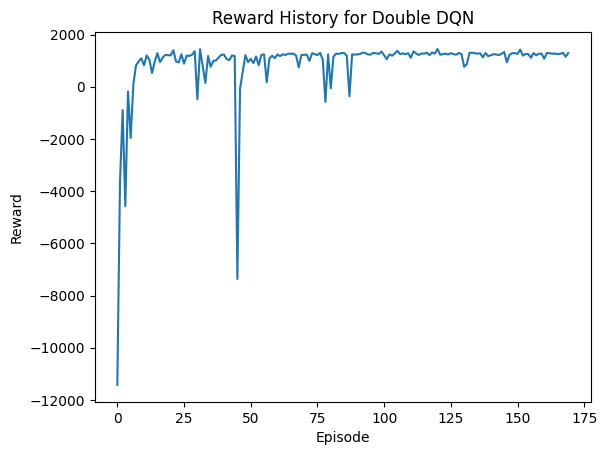

In [ ]:
# plot the reward history
import matplotlib.pyplot as plt
plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward History for Double DQN')
plt.show()


In [ ]:
#save model
agent.policy_model.save('./models/D-DQN_RCmaze_v3.h5')


/home/lucasdriessens/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## test

In [ ]:
# try it out
# load model
env = RCMazeEnv()
state = env.reset()

env.init_pygame()

REPLAY_MEMORY_CAPACITY = 20000
POSSIBLE_ACTIONS = env.possible_actions

# create DQN agent
test_agent = DQAgent(replayCapacity=REPLAY_MEMORY_CAPACITY, input_shape=state.shape, output_shape=len(POSSIBLE_ACTIONS))


from keras.models import load_model
test_agent.policy_model = load_model('./models/D-DQN_RCmaze_v3.h5')


done = False

rewards = []

while not done:
    env.render(delay=100, framerate=60)
   
    qValues = test_agent.policy_network_predict(np.array([state]))
    action = np.argmax(qValues[0])
    state, reward, done = env.step(action)
    rewards.append(reward)
    
    env.render()
    if done:
        print('done in ', len(rewards), 'steps')
        break
env.close()
print(sum(rewards))
env.close_pygame()


2024-01-09 10:49:38.994738: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_159/bias/Assign' id:10571 op device:{requested: '', assigned: ''} def:{{{node dense_159/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_159/bias, dense_159/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-09 10:49:39.348865: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_144_1/bias/Assign' id:10789 op device:{requested: '', assigned: ''} def:{{{node dense_144_1/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_144_1/bias, dense_144_1/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an

done in  34 steps
1296.992428778307


In [ ]:
env.close_pygame()

## conclusions

The double DQN is able to solve the environment in less episodes than the DQN. This is a great imporvement for when when we will want to apply real time learning.

# PPO

In [ ]:
import numpy as np

import gym
from gym import spaces

import pygame

class RCMazeEnv(gym.Env):
    def __init__(self, maze_size_x=12, maze_size_y=12):
        self.maze_size_x = maze_size_x
        self.maze_size_y = maze_size_y
        self.maze = self.generate_maze()
        self.car_position = (1, 1)
        self.possible_actions = range(3)
        self.car_orientation = 'N'
        self.sensor_readings = {'front': 0, 'left': 0, 'right': 0}
        self.steps = 0
        self.previous_distance = 0
        self.goal = (10, 10)
        self.previous_steps = 0
        self.visited_positions = set()
        self.reset()

            
    def generate_maze(self):
        # For simplicity, create a static maze with walls
        # '1' represents a wall, and '0' represents an open path
        maze = np.zeros((self.maze_size_y, self.maze_size_x), dtype=int)
        # Add walls to the maze (this can be customized)

        
        layout = [
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
            [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
            [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1],
            [1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1],
            [1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1],
            [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
        
     
        maze = np.array(layout)

        return maze

    def reset(self):
        self.car_position = (1, 1)
        self.car_orientation = 'N'
        self.update_sensor_readings()
        self.steps = 0
        self.previous_distance = 0
        self.previous_steps = 0
        self.visited_positions.clear()  # Clear the visited positions
        self.visited_positions.add(self.car_position)
        return self.get_state()

    def step(self, action):
        if action == 0:
            self.move_forward()
        elif action == 1:
            self.turn_left()
        elif action == 2:
            self.turn_right()
        self.update_sensor_readings()
        self.visited_positions.add(self.car_position)
        reward = self.compute_reward()
        self.steps += 1
        done = self.is_done()
        return self.get_state(), reward, done

    
    def move_forward(self):
        x, y = self.car_position
        if self.car_orientation == 'N' and y > 0 and self.maze[y - 1][x] != 1:
            self.car_position = (x, y - 1)
        elif self.car_orientation == 'S' and y < self.maze_size_y - 1 and self.maze[y + 1][x] != 1:
            self.car_position = (x, y + 1)
        elif self.car_orientation == 'E' and x < self.maze_size_x - 1 and self.maze[y][x + 1] != 1:
            self.car_position = (x + 1, y)
        elif self.car_orientation == 'W' and x > 0 and self.maze[y][x - 1] != 1:
            self.car_position = (x - 1, y)
        

    def turn_left(self):
        orientations = ['N', 'W', 'S', 'E']
        idx = orientations.index(self.car_orientation)
        self.car_orientation = orientations[(idx + 1) % 4]

    def turn_right(self):
        orientations = ['N', 'E', 'S', 'W']
        idx = orientations.index(self.car_orientation)
        self.car_orientation = orientations[(idx + 1) % 4]

    def update_sensor_readings(self):
        # Simple sensor implementation: counts steps to the nearest wall
        self.sensor_readings['front'] = self.distance_to_wall('front')
        self.sensor_readings['left'] = self.distance_to_wall('left')
        self.sensor_readings['right'] = self.distance_to_wall('right')

    def distance_to_wall(self, direction):
        x, y = self.car_position
        distance = 0
        max_distance = self.maze_size_x if direction in ['left', 'right'] else self.maze_size_y

        
        if direction == 'front':
            if self.car_orientation == 'N':
                while y - distance >= 0 and self.maze[y - distance][x] != 1:
                    distance += 1
            elif self.car_orientation == 'S':
                while y + distance < self.maze_size_y and self.maze[y + distance][x] != 1:
                    distance += 1
            elif self.car_orientation == 'E':
                while x + distance < self.maze_size_x and self.maze[y][x + distance] != 1:
                    distance += 1
            elif self.car_orientation == 'W':
                while x - distance >= 0 and self.maze[y][x - distance] != 1:
                    distance += 1
        elif direction == 'left':
            if self.car_orientation == 'N':
                while x - distance >= 0 and self.maze[y][x - distance] != 1:
                    distance += 1
            elif self.car_orientation == 'S':
                while x + distance < self.maze_size_x and self.maze[y][x + distance] != 1:
                    distance += 1
            elif self.car_orientation == 'E':
                while y - distance >= 0 and self.maze[y - distance][x] != 1:
                    distance += 1
            elif self.car_orientation == 'W':
                while y + distance < self.maze_size_y and self.maze[y + distance][x] != 1:
                    distance += 1
        elif direction == 'right':
            if self.car_orientation == 'N':
                while x + distance < self.maze_size_x and self.maze[y][x + distance] != 1:
                    distance += 1
            elif self.car_orientation == 'S':
                while x - distance >= 0 and self.maze[y][x - distance] != 1:
                    distance += 1
            elif self.car_orientation == 'E':
                while y + distance < self.maze_size_y and self.maze[y + distance][x] != 1:
                    distance += 1
            elif self.car_orientation == 'W':
                while y - distance >= 0 and self.maze[y - distance][x] != 1:
                    distance += 1
        
            # Normalize the measured distance
        normalized_distance = (max_distance - distance - 1) / (max_distance - 1)

        # Ensure the value is within the range [0, 1]
        normalized_distance = max(0, min(normalized_distance, 1))

        return normalized_distance
    
    def compute_reward(self):
        # Initialize reward
        reward = 0

        # Check for collision or out of bounds
        if any(self.sensor_readings[direction] == 0 for direction in ['front', 'left', 'right']):
            reward -= 20

        # Check if goal is reached
        if self.car_position == self.goal:
            reward += 500
            # Additional penalty if it takes too many steps to reach the goal
            if self.steps > 1000:
                reward -= 200
            return reward  # Return immediately as this is the terminal state

        # Calculate the Euclidean distance to the goal
        distance_to_goal = ((self.car_position[0] - self.goal[0]) ** 2 + (self.car_position[1] - self.goal[1]) ** 2) ** 0.5

        # Define a maximum reward when the car is at the goal
        max_reward_at_goal = 50

        # Reward based on proximity to the goal
        reward += max_reward_at_goal / (distance_to_goal + 1)  # Adding 1 to avoid division by zero

        # # Reward or penalize based on movement towards or away from the goal
        if distance_to_goal < self.previous_distance:
            reward += 50  # Positive reward for moving closer to the goal
        elif distance_to_goal > self.previous_distance:
            reward -= 25  # Negative reward for moving farther from the goal

        if self.car_position in self.visited_positions:
            # Apply a penalty for revisiting the same position
            reward -= 10
            
        # Penalize for each step taken to encourage efficiency
        reward -= 2
        
        # Update the previous_distance for the next step
        self.previous_distance = distance_to_goal
        return reward

    def is_done(self):
        #is done if it reaches the goal or goes out of bounds or takes more than 3000 steps
        return self.car_position == self.goal or self.steps > 3000 or self.car_position[0] < 0 or self.car_position[1] < 0 or self.car_position[0] > 11 or self.car_position[1] > 11
        
    def get_state(self):
        car_position = [float(coord) for coord in self.car_position]
        sensor_readings = [float(value) for value in self.sensor_readings.values()]
        
        state = car_position + [self.car_orientation] + sensor_readings
        
        # cast state to this ['1.0' '1.0' 'N' '1.0' '1.0' '10.0']
        state = np.array(state, dtype=str)
        
        #get the orientation and convert do label encoding
        if state[2] == 'N':
            state[2] = 0
        elif state[2] == 'E':
            state[2] = 1
        elif state[2] == 'S':
            state[2] = 2
        elif state[2] == 'W':
            state[2] = 3
            
        state = np.array(state, dtype=float)
        
        return state

    
    def init_pygame(self):
        # Initialize Pygame and set up the display
        pygame.init()
        self.cell_size = 40  # Size of each cell in pixels
        self.maze_size_x = 12  # Assuming the maze size_x is 12
        self.maze_size_y = 12  # Assuming the maze size_y is 12
        self.width = 600
        self.height = 600
        self.screen = pygame.display.set_mode((self.width, self.height))
        self.clock = pygame.time.Clock()

    def render(self, framerate=60, delay=0):
        # Render the environment using Pygame
        for y in range(self.maze_size_y):
            for x in range(self.maze_size_x):
                rect = pygame.Rect(x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size)
                if (x, y) == self.goal:  # Goal position
                    color = (0, 255, 0)  # Green color for the goal
                elif self.maze[y][x] == 0:
                    color = (255, 255, 255)  # White color for empty space
                else:
                    color = (0, 0, 0)  # Black color for walls
                pygame.draw.rect(self.screen, color, rect)
        
        # Draw the car
        car_x, car_y = self.car_position
        car_rect = pygame.Rect(car_x * self.cell_size, car_y * self.cell_size, self.cell_size, self.cell_size)
        pygame.draw.rect(self.screen, (255, 0, 0), car_rect)  # Red color for the car
        pygame.time.delay(delay)
        pygame.display.flip()
        self.clock.tick(framerate)  # Limit the frame rate to 60 FPS


    def close_pygame(self):
        # Close the Pygame window
        pygame.quit()

In [ ]:
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay

class REINFORCE:
    def __init__(self, env, input_shape, alpha=1e-4, gamma=0.99, learning_rate=0.001, batch_size=64, epsilon=0.99, epsilon_decay=0.993, epsilon_min=0.01):
        self.env = env
        self.state_shape = input_shape
        self.action_shape = len(env.possible_actions)
        self.gamma = gamma
        self.alpha = alpha
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.model = self.build_policy_network()
        self.states = []
        self.gradients = []
        self.rewards = []
        self.probs = []
        self.total_rewards = []
        self.batch_rewards = []
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
    
    def build_policy_network(self):
        # Enhanced network architecture
        model = Sequential()
        model.add(Input(shape=self.state_shape))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(self.action_shape, activation='softmax'))
        
        optimizer = Adam(learning_rate=self.learning_rate)

        model.compile(loss='categorical_crossentropy', optimizer=optimizer)
        return model

    def hot_encode_action(self, action):
        action_encoded = np.zeros(self.action_shape)
        action_encoded[action] = 1
        return action_encoded

    def remember(self, state, action, action_prob, reward):
        encoded_action = self.hot_encode_action(action)
        self.gradients.append(encoded_action - action_prob)
        self.states.append(state)
        self.rewards.append(reward)
        self.probs.append(action_prob)

    def compute_action(self, state):
        if np.random.rand() < self.epsilon:
            # Exploration: choose a random action
            action = np.random.choice(self.action_shape)
            action_probability_distribution = np.ones(self.action_shape) / self.action_shape
        else:
            # Exploitation: choose action based on policy
            state = state.reshape([1, state.shape[0]])
            action_probability_distribution = self.model.predict(state).flatten()
            action_probability_distribution /= np.sum(action_probability_distribution)
            action = np.random.choice(self.action_shape, 1, p=action_probability_distribution)[0]
        
        return action, action_probability_distribution

    def get_discounted_rewards(self, rewards):
        discounted_rewards = []
        cumulative_total_return = 0
        for reward in rewards[::-1]:
            cumulative_total_return = (cumulative_total_return * self.gamma) + reward
            discounted_rewards.insert(0, cumulative_total_return)

        mean_rewards = np.mean(discounted_rewards)
        std_rewards = np.std(discounted_rewards)
        norm_discounted_rewards = (discounted_rewards - mean_rewards) / (std_rewards + 1e-7)
        return norm_discounted_rewards

    def train_policy_network(self):
        states = np.vstack(self.states)
        gradients = np.vstack(self.gradients)
        rewards = np.vstack(self.rewards)
        discounted_rewards = self.get_discounted_rewards(rewards)
        gradients *= discounted_rewards
        y_train = self.alpha * gradients + self.probs

        # Gradient clipping
        self.model.optimizer.get_gradients = lambda loss, vars: [
            tf.clip_by_value(g, -1., 1.) for g in tf.gradients(loss, vars)]

        history = self.model.train_on_batch(states, y_train)
        self.states, self.probs, self.gradients, self.rewards = [], [], [], []
        return history

    def train(self, episodes):
        env = self.env
        total_rewards = np.zeros(episodes)
        reward_history = []
        episode_count = 0

        for episode in range(episodes):
            state = env.reset()
            done = False
            episode_reward = 0

            while not done:
                action, prob = self.compute_action(state)
                next_state, reward, done = env.step(action)
                self.remember(state, action, prob, reward)
                state = next_state
                episode_reward += reward
                env.render(delay=0, framerate=360)

                if done:
                    episode_count += 1
                
                # do a batch update every 2 episodes
                
                    
                if episode_count % 2 == 0:
                    states = np.vstack(self.states)
                    gradients = np.vstack(self.gradients)
                    rewards = np.vstack(self.rewards)
                    discounted_rewards = self.get_discounted_rewards(rewards)
                    gradients *= discounted_rewards
                    y_train = self.alpha * gradients + self.probs
                    self.train_policy_network()
                    episode_count = 0

            total_rewards[episode] = episode_reward
            reward_history.append(episode_reward)

            # Epsilon decay
            self.epsilon = max(self.epsilon_min, self.epsilon_decay * self.epsilon)

            print(f'Episode: {episode}, Reward: {episode_reward}, Epsilon: {self.epsilon}')

            
            # Improved early stopping based on recent reward history
            if len(reward_history) > 10:
                last_10_rewards = reward_history[-10:]
                if all(reward > 0 for reward in last_10_rewards):
                    differences = [abs(last_10_rewards[i] - last_10_rewards[i-1]) for i in range(1, 10)]
                    if all(diff < 200 for diff in differences):
                        print('The difference between each of the last 10 positive rewards is less than 200, stopping training')
                        break

        self.total_rewards = total_rewards
        return reward_history
    
    def test(self, episodes, render=False):
        env = self.env
        total_rewards = np.zeros(episodes)

        for episode in range(episodes):
            state = env.reset()
            done = False
            episode_reward = 0

            while not done:
                action = self.compute_action_for_testing(state)
                next_state, reward, done, _ = env.step(action)
                state = next_state
                episode_reward += reward

                if render:
                    env.render()

            total_rewards[episode] = episode_reward
            print(f'Episode: {episode}, Reward: {episode_reward}')

        average_reward = np.mean(total_rewards)
        print(f'Average Reward: {average_reward}')
        return total_rewards

    def compute_action_for_testing(self, state):
        state = state.reshape([1, state.shape[0]])
        action_probability_distribution = self.model.predict(state).flatten()
        action = np.argmax(action_probability_distribution)
        return action

    def hot_encode_action(self, action):

        action_encoded=np.zeros(self.action_shape)
        action_encoded[action]=1

        return action_encoded
    
    def remember(self, state, action, action_prob, reward):

        encoded_action=self.hot_encode_action(action)
        self.gradients.append(encoded_action-action_prob)
        self.states.append(state)
        self.rewards.append(reward)
        self.probs.append(action_prob)
  

In [ ]:
# play env
env= RCMazeEnv()

alpha = 0.0001
gamma = 0.99
learning_rate = 0.001
EPSILON = 0.99
epsilon_decay = 0.993

N_EPISODES=200

env.init_pygame()

state = env.reset() # reset to env 
Agent = REINFORCE(env,input_shape=state.shape, epsilon=EPSILON, epsilon_decay=epsilon_decay , alpha=alpha, gamma=gamma, learning_rate=learning_rate)

rewards = Agent.train(N_EPISODES)
env.close_pygame()
env.close()

2024-01-08 20:01:16.387381: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_134/kernel/Assign' id:8422 op device:{requested: '', assigned: ''} def:{{{node dense_134/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_134/kernel, dense_134/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Episode: 0, Reward: -13712.0934387075, Epsilon: 0.98307
Episode: 1, Reward: -13518.754816315082, Epsilon: 0.97618851
Episode: 2, Reward: -16256.211941779733, Epsilon: 0.96935519043
Episode: 3, Reward: -13861.863455093655, Epsilon: 0.9625697040969899


2024-01-08 20:01:32.650564: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_26/mul' id:8528 op device:{requested: '', assigned: ''} def:{{{node loss_26/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_26/mul/x, loss_26/dense_136_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-08 20:01:32.749476: W tensorflow/c/c_api.cc:305] Operation '{name:'training_30/Adam/dense_133/kernel/v/Assign' id:8699 op device:{requested: '', assigned: ''} def:{{{node training_30/Adam/dense_133/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_30/Adam/dense_133/kernel/v, training_30/Adam/dense_133/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will 

Episode: 4, Reward: -14504.064256371481, Epsilon: 0.955831716168311
Episode: 5, Reward: -8333.766500658516, Epsilon: 0.9491408941551328
Episode: 6, Reward: -2042.5687680249512, Epsilon: 0.9424969078960469
Episode: 7, Reward: -11629.254434039896, Epsilon: 0.9358994295407745
Episode: 8, Reward: -15392.215518888084, Epsilon: 0.9293481335339892
Episode: 9, Reward: -9823.55093472093, Epsilon: 0.9228426965992512
Episode: 10, Reward: -6513.063924713134, Epsilon: 0.9163827977230564
Episode: 11, Reward: -10260.229653200151, Epsilon: 0.909968118138995
Episode: 12, Reward: -11511.029123478806, Epsilon: 0.9035983413120221
Episode: 13, Reward: -13527.035256487188, Epsilon: 0.8972731529228379
Episode: 14, Reward: -519.2562775240173, Epsilon: 0.890992240852378
Episode: 15, Reward: -13368.248798453049, Epsilon: 0.8847552951664114
Episode: 16, Reward: -14941.694239593373, Epsilon: 0.8785620081002465
Episode: 17, Reward: -4989.705376411176, Epsilon: 0.8724120740435448
Episode: 18, Reward: 317.1400640836

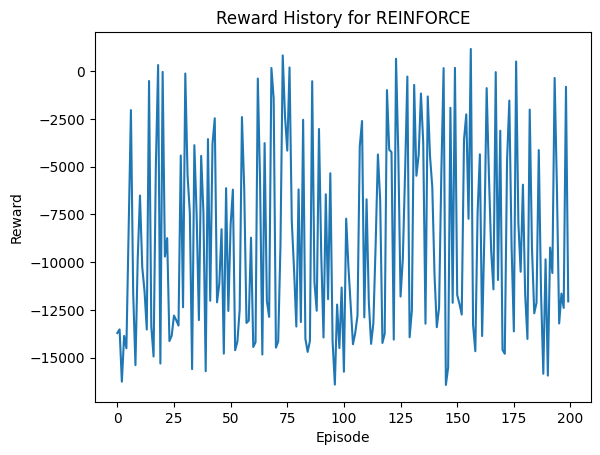

In [ ]:
#plot the reward history
import matplotlib.pyplot as plt
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward History for REINFORCE')
plt.show()


In [ ]:
# save model
Agent.model.save('./models/REINFORCE_RCmaze.h5')

/home/lucasdriessens/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# test
env = RCMazeEnv()
state = env.reset()

env.init_pygame()

from keras.models import load_model
Agent = REINFORCE(env, input_shape=state.shape)
Agent.model = load_model('./models/REINFORCE_RCmaze.h5')

done = False

rewards = []

while not done:
    env.render(delay=100, framerate=360)
   
    action, prob = Agent.compute_action(state)
    state, reward, done = env.step(action)
    rewards.append(reward)
    
    env.render()
    if done:
        print('done in ', len(rewards), 'steps')
        break
      
env.close()
print(sum(rewards))
env.close_pygame()


## conclusions

The PPO is not able to consistently solve the environment. There could be a solution to this, but since my DQN is able to solve it without any problems I will just keep using that.

# fixing the distance to wall function

In [ ]:
from OpenGL.GL import *
from OpenGL.GLUT import *
from OpenGL.GLU import *

In [ ]:
import numpy as np

import gym
from gym import spaces

import pygame

class RCMazeEnv(gym.Env):
    def __init__(self, maze_size_x=12, maze_size_y=12):
        self.maze_size_x = maze_size_x
        self.maze_size_y = maze_size_y
        self.maze = self.generate_maze()
        self.car_position = (1, 1)
        self.possible_actions = range(3)
        self.car_orientation = 'N'
        self.sensor_readings = {'front': 0, 'left': 0, 'right': 0}
        self.steps = 0
        self.previous_distance = 0
        self.goal = (10, 10)
        self.previous_steps = 0
        self.visited_positions = set()
        self.reset()

            
    def generate_maze(self):
        # For simplicity, create a static maze with walls
        # '1' represents a wall, and '0' represents an open path
        maze = np.zeros((self.maze_size_y, self.maze_size_x), dtype=int)
        # Add walls to the maze (this can be customized)

        
        layout = [
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
            [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
            [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1],
            [1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1],
            [1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1],
            [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
        
     
        maze = np.array(layout)

        return maze

    def reset(self):
        self.car_position = (1, 1)
        self.car_orientation = 'N'
        self.update_sensor_readings()
        self.steps = 0
        self.previous_distance = 0
        self.previous_steps = 0
        self.visited_positions.clear()  # Clear the visited positions
        self.visited_positions.add(self.car_position)
        return self.get_state()

    def step(self, action):
        if action == 0:
            self.move_forward()
        elif action == 1:
            self.turn_left()
        elif action == 2:
            self.turn_right()
        self.update_sensor_readings()
        self.visited_positions.add(self.car_position)
        reward = self.compute_reward()
        self.steps += 1
        done = self.is_done()
        return self.get_state(), reward, done

    
    def move_forward(self):
        x, y = self.car_position
        if self.car_orientation == 'N' and y > 0 and self.maze[y - 1][x] != 1:
            self.car_position = (x, y - 1)
        elif self.car_orientation == 'S' and y < self.maze_size_y - 1 and self.maze[y + 1][x] != 1:
            self.car_position = (x, y + 1)
        elif self.car_orientation == 'E' and x < self.maze_size_x - 1 and self.maze[y][x + 1] != 1:
            self.car_position = (x + 1, y)
        elif self.car_orientation == 'W' and x > 0 and self.maze[y][x - 1] != 1:
            self.car_position = (x - 1, y)
        

    def turn_left(self):
        orientations = ['N', 'W', 'S', 'E']
        idx = orientations.index(self.car_orientation)
        self.car_orientation = orientations[(idx + 1) % 4]

    def turn_right(self):
        orientations = ['N', 'E', 'S', 'W']
        idx = orientations.index(self.car_orientation)
        self.car_orientation = orientations[(idx + 1) % 4]

    def update_sensor_readings(self):
        # Simple sensor implementation: counts steps to the nearest wall
        self.sensor_readings['front'] = self.distance_to_wall('front')
        self.sensor_readings['left'] = self.distance_to_wall('left')
        self.sensor_readings['right'] = self.distance_to_wall('right')

    def distance_to_wall(self, direction):
        x, y = self.car_position
        sensor_max_range = 255  # Maximum range of the ultrasonic sensor

        def calculate_distance(dx, dy):
            distance = 0
            while 0 <= x + distance * dx < self.maze_size_x and \
                0 <= y + distance * dy < self.maze_size_y and \
                self.maze[y + distance * dy][x + distance * dx] != 1:
                distance += 1
                if distance > sensor_max_range:  # Limiting the sensor range
                    break
            return distance

        if direction == 'front':
            if self.car_orientation == 'N':
                distance = calculate_distance(0, -1)
            elif self.car_orientation == 'S':
                distance = calculate_distance(0, 1)
            elif self.car_orientation == 'E':
                distance = calculate_distance(1, 0)
            elif self.car_orientation == 'W':
                distance = calculate_distance(-1, 0)

        elif direction == 'left':
            if self.car_orientation == 'N':
                distance = calculate_distance(-1, 0)
            elif self.car_orientation == 'S':
                distance = calculate_distance(1, 0)
            elif self.car_orientation == 'E':
                distance = calculate_distance(0, -1)
            elif self.car_orientation == 'W':
                distance = calculate_distance(0, 1)

        elif direction == 'right':
            if self.car_orientation == 'N':
                distance = calculate_distance(1, 0)
            elif self.car_orientation == 'S':
                distance = calculate_distance(-1, 0)
            elif self.car_orientation == 'E':
                distance = calculate_distance(0, 1)
            elif self.car_orientation == 'W':
                distance = calculate_distance(0, -1)

        # Normalize the distance to a range of 0-1
        normalized_distance = distance / sensor_max_range
        normalized_distance = max(0, min(normalized_distance, 1))

        return normalized_distance
    
    def compute_reward(self):
        # Initialize reward
        reward = 0

        # Check for collision or out of bounds
        if any(self.sensor_readings[direction] == 0 for direction in ['front', 'left', 'right']):
            reward -= 20

        # Check if goal is reached
        if self.car_position == self.goal:
            reward += 500
            # Additional penalty if it takes too many steps to reach the goal
            if self.steps > 1000:
                reward -= 200
            return reward  # Return immediately as this is the terminal state

        # Calculate the Euclidean distance to the goal
        distance_to_goal = ((self.car_position[0] - self.goal[0]) ** 2 + (self.car_position[1] - self.goal[1]) ** 2) ** 0.5

        # Define a maximum reward when the car is at the goal
        max_reward_at_goal = 50

        # Reward based on proximity to the goal
        reward += max_reward_at_goal / (distance_to_goal + 1)  # Adding 1 to avoid division by zero

        # # Reward or penalize based on movement towards or away from the goal
        if distance_to_goal < self.previous_distance:
            reward += 50  # Positive reward for moving closer to the goal
        elif distance_to_goal > self.previous_distance:
            reward -= 25  # Negative reward for moving farther from the goal

        if self.car_position in self.visited_positions:
            # Apply a penalty for revisiting the same position
            reward -= 10
            
        # Penalize for each step taken to encourage efficiency
        reward -= 2
        
        # Update the previous_distance for the next step
        self.previous_distance = distance_to_goal
        return reward

    def is_done(self):
        #is done if it reaches the goal or goes out of bounds or takes more than 3000 steps
        return self.car_position == self.goal or self.steps > 3000 or self.car_position[0] < 0 or self.car_position[1] < 0 or self.car_position[0] > 11 or self.car_position[1] > 11
        
    def get_state(self):
        car_position = [float(coord) for coord in self.car_position]
        sensor_readings = [float(value) for value in self.sensor_readings.values()]
        
        state = car_position + [self.car_orientation] + sensor_readings
        
        # cast state to this ['1.0' '1.0' 'N' '1.0' '1.0' '10.0']
        state = np.array(state, dtype=str)
        
        #get the orientation and convert do label encoding
        if state[2] == 'N':
            state[2] = 0
        elif state[2] == 'E':
            state[2] = 1
        elif state[2] == 'S':
            state[2] = 2
        elif state[2] == 'W':
            state[2] = 3
            
        state = np.array(state, dtype=float)
        
        return state

    
    def init_pygame(self):
        # Initialize Pygame and set up the display
        pygame.init()
        self.cell_size = 40  # Size of each cell in pixels
        self.maze_size_x = 12  # Assuming the maze size_x is 12
        self.maze_size_y = 12  # Assuming the maze size_y is 12
        self.width = 600
        self.height = 600
        self.screen = pygame.display.set_mode((self.width, self.height))
        self.clock = pygame.time.Clock()

    def render(self, framerate=60, delay=0):
        # Render the environment using Pygame
        for y in range(self.maze_size_y):
            for x in range(self.maze_size_x):
                rect = pygame.Rect(x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size)
                if (x, y) == self.goal:  # Goal position
                    color = (0, 255, 0)  # Green color for the goal
                elif self.maze[y][x] == 0:
                    color = (255, 255, 255)  # White color for empty space
                else:
                    color = (0, 0, 0)  # Black color for walls
                pygame.draw.rect(self.screen, color, rect)
        
        # Draw the car
        car_x, car_y = self.car_position
        car_rect = pygame.Rect(car_x * self.cell_size, car_y * self.cell_size, self.cell_size, self.cell_size)
        pygame.draw.rect(self.screen, (255, 0, 0), car_rect)  # Red color for the car
        pygame.time.delay(delay)
        pygame.display.flip()
        self.clock.tick(framerate)  # Limit the frame rate to 60 FPS


    def close_pygame(self):
        # Close the Pygame window
        pygame.quit()

In [ ]:
from tensorflow.keras.optimizers.legacy import Adam
class DQAgent:
    def __init__(self, replayCapacity, input_shape, output_shape, learning_rate=0.001, discount_factor=0.90):
        self.capacity = replayCapacity
        self.memory = collections.deque(maxlen=self.capacity)
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.policy_model = self.buildNetwork()
        self.target_model = self.buildNetwork()
        self.target_model.set_weights(self.policy_model.get_weights())


    def addToReplayMemory(self, step):
        self.step = step
        self.memory.append(self.step)

    def sampleFromReplayMemory(self, batchSize):
        self.batchSize = batchSize
        if self.batchSize > len(self.memory):
            self.populated = False
            return self.populated
        else:
            return random.sample(self.memory, self.batchSize)


    def buildNetwork(self):
        model = Sequential()
        model.add(Dense(128, input_shape=self.input_shape, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(512, activation='relu'))
        model.add(Dense(1028, activation='relu'))
        model.add(Dense(512, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(self.output_shape, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate), metrics=['MeanSquaredError'])
        return model

    def policy_network_fit(self, batch, batch_size):
            states, actions, rewards, next_states, dones = zip(*batch)

            states = np.array(states)
            next_states = np.array(next_states)

            # Predict Q-values for starting state using the policy network
            q_values = self.policy_model.predict(states)

            # Predict Q-values for next state using the policy network
            q_values_next_state_policy = self.policy_model.predict(next_states)

            # Select the best action for the next state using the policy network
            best_actions = np.argmax(q_values_next_state_policy, axis=1)

            # Predict Q-values for next state using the target network
            q_values_next_state_target = self.target_model.predict(next_states)

            # Update Q-values for actions taken
            for i in range(batch_size):
                if dones[i]:
                    q_values[i, actions[i]] = rewards[i]
                else:
                    # Double DQN update rule
                    q_values[i, actions[i]] = rewards[i] + self.discount_factor * q_values_next_state_target[i, best_actions[i]]

            # Train the policy network
            self.policy_model.fit(states, q_values, batch_size=batch_size, verbose=0)

    def policy_network_predict(self, state):
        self.state = state
        self.qPolicy = self.policy_model.predict(self.state)
        return self.qPolicy

    def target_network_predict(self, state):
        self.state = state
        self.qTarget = self.target_model.predict(self.state)
        return self.qTarget

    def update_target_network(self):
        self.target_model.set_weights(self.policy_model.get_weights())

In [ ]:
env = RCMazeEnv()
state = env.reset()

env.init_pygame()

# Model parameters
REPLAY_MEMORY_CAPACITY = 200000
# MIN_REPLAY_MEMORY_SIZE = 1_000  # Minimum number of steps in a memory to start training
POSSIBLE_ACTIONS = env.possible_actions

# state = state[0]
# create DQN agent
agent = DQAgent(replayCapacity=REPLAY_MEMORY_CAPACITY, 
                input_shape=state.shape, 
                output_shape=len(POSSIBLE_ACTIONS),
                learning_rate=0.001, 
                discount_factor=0.90)


# reset the parameters
DISCOUNT = 0.90
BATCH_SIZE = 64  # How many steps (samples) to use for training
UPDATE_TARGET_INTERVAL = 5
EPSILON = 1.0 # Exploration percentage
MIN_EPSILON = 0.001
DECAY = 0.99999
EPISODE_AMOUNT = 170



# Fill the replay memory with the first batch of samples
update_counter = 0
reward_history = []
epsilon_history = []

np.set_printoptions(precision=3, suppress=True)

for episode in range(EPISODE_AMOUNT):
    episode_reward = 0
    step_counter = 0  # count the number of successful steps within the episode
    
    state = env.reset()
    done = False
    epsilon_history.append(EPSILON)
    
   #  early stopping
    if len(reward_history) > 10:
        last_10_rewards = reward_history[-10:]
        if all(reward > 0 for reward in last_10_rewards):
            differences = [abs(last_10_rewards[i] - last_10_rewards[i-1]) for i in range(1, 10)]
            if all(diff < 200 for diff in differences):
                print('The difference between each of the last 10 positive rewards is less than 200, stopping training')
                break
    while not done:
        env.render(delay=0, framerate=360)

        if random.random() <= EPSILON:
            action = random.sample(POSSIBLE_ACTIONS, 1)[0]
        else:
            qValues = agent.policy_network_predict(state.reshape(1,-1))
            action = np.argmax(qValues[0])

        new_state, reward, done = env.step(action)

        step_counter +=1

        # store step in replay memory
        step = (state, action, reward, new_state, done)
        agent.addToReplayMemory(step)
        state = new_state
        episode_reward += reward
        # When enough steps in replay memory -> train policy network
        if len(agent.memory) >= BATCH_SIZE * 10:
            EPSILON = DECAY * EPSILON
            if EPSILON < MIN_EPSILON:
                EPSILON = MIN_EPSILON
            # sample minibatch from replay memory
            
            miniBatch = agent.sampleFromReplayMemory(BATCH_SIZE)
            miniBatch_states = np.asarray(list(zip(*miniBatch))[0],dtype=float)
            miniBatch_actions = np.asarray(list(zip(*miniBatch))[1], dtype = int)
            miniBatch_rewards = np.asarray(list(zip(*miniBatch))[2], dtype = float)
            miniBatch_next_state = np.asarray(list(zip(*miniBatch))[3],dtype=float)
            miniBatch_done = np.asarray(list(zip(*miniBatch))[4],dtype=bool)
            
            # current state q values1tch_states)
            y = agent.policy_network_predict(miniBatch_states)

            next_state_q_values = agent.target_network_predict(miniBatch_next_state)
            max_q_next_state = np.max(next_state_q_values,axis=1)

            for i in range(BATCH_SIZE):
                if miniBatch_done[i]:
                    y[i,miniBatch_actions[i]] = miniBatch_rewards[i]
                else:
                    y[i,miniBatch_actions[i]] = miniBatch_rewards[i] + DISCOUNT *  max_q_next_state[i]
                    
            agent.policy_model.fit(miniBatch_states, y, batch_size=BATCH_SIZE, verbose = 0)
            
        else:
            continue
        if update_counter == UPDATE_TARGET_INTERVAL:
            agent.update_target_network()
            update_counter = 0
        update_counter += 1
    print('episodeReward for episode ', episode, '= ', episode_reward, 'with epsilon = ', EPSILON)
    reward_history.append(episode_reward)
    

env.close_pygame()
env.close()

2024-01-09 11:25:45.954453: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_134/kernel/Assign' id:6894 op device:{requested: '', assigned: ''} def:{{{node dense_134/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_134/kernel, dense_134/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-09 11:25:47.475609: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_131/BiasAdd' id:6789 op device:{requested: '', assigned: ''} def:{{{node dense_131/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_131/MatMul, dense_131/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an err

episodeReward for episode  0 =  -12128.965594700352 with epsilon =  0.9776826866700326
episodeReward for episode  1 =  -5789.674073340795 with epsilon =  0.9564371288349841
episodeReward for episode  2 =  -7015.820503938914 with epsilon =  0.9351668324785439
episodeReward for episode  3 =  -806.5202171271512 with epsilon =  0.9288478154333734
episodeReward for episode  4 =  -564.3579963506436 with epsilon =  0.9209031441904374
episodeReward for episode  5 =  828.2626601978978 with epsilon =  0.9174837314479588
episodeReward for episode  6 =  193.36043439827222 with epsilon =  0.9127708128483631
episodeReward for episode  7 =  -447.0936357327613 with epsilon =  0.9086634649771337
episodeReward for episode  8 =  343.3342999133106 with epsilon =  0.9066665927346911
episodeReward for episode  9 =  730.5101621823173 with epsilon =  0.9050903567051793
episodeReward for episode  10 =  218.42090212138294 with epsilon =  0.8999189932101364
episodeReward for episode  11 =  86.00446481688982 with

In [ ]:
env.close_opengl()
env.close()

AttributeError: 'RCMazeEnv' object has no attribute 'close_opengl'

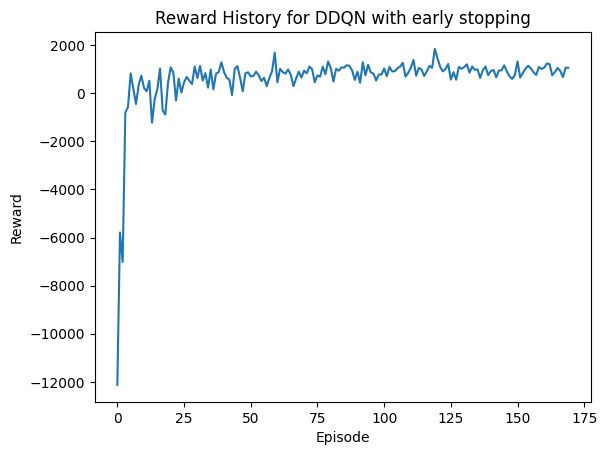

In [ ]:
#plot reward history
import matplotlib.pyplot as plt
plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward History for DDQN with early stopping')
plt.show()

In [ ]:
# save model
agent.policy_model.save('./models/DDQN_RCmaze_ES.h5')

/home/lucasdriessens/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## test

In [ ]:
#test the model
# try it out
# load model
env = RCMazeEnv()
state = env.reset()

env.init_pygame()

REPLAY_MEMORY_CAPACITY = 20000
POSSIBLE_ACTIONS = env.possible_actions

# create DQN agent
test_agent = DQAgent(replayCapacity=REPLAY_MEMORY_CAPACITY, input_shape=state.shape, output_shape=len(POSSIBLE_ACTIONS))


from keras.models import load_model
test_agent.policy_model = load_model('./models/DDQN_RCmaze_ES.h5')


done = False

rewards = []

while not done:
    env.render(delay=100, framerate=60)
   
    qValues = test_agent.policy_network_predict(np.array([state]))
    action = np.argmax(qValues[0])
    state, reward, done = env.step(action)
    rewards.append(reward)
    
    env.render()
    if done:
        print('done in ', len(rewards), 'steps')
        break
env.close()
print(sum(rewards))
env.close_pygame()


2024-01-09 11:32:30.931827: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_142/bias/Assign' id:7638 op device:{requested: '', assigned: ''} def:{{{node dense_142/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_142/bias, dense_142/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-09 11:32:31.314339: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_124_1/bias/Assign' id:8149 op device:{requested: '', assigned: ''} def:{{{node dense_124_1/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_124_1/bias, dense_124_1/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an e

done in  34 steps
1296.992428778307


## trying to lower the amount of episodes needed

In [104]:
import numpy as np

import gym
from gym import spaces

import pygame

class RCMazeEnv(gym.Env):
    def __init__(self, maze_size_x=12, maze_size_y=12):
        self.maze_size_x = maze_size_x
        self.maze_size_y = maze_size_y
        self.maze = self.generate_maze()
        self.car_position = (1, 1)
        self.possible_actions = range(3)
        self.car_orientation = 'N'
        self.sensor_readings = {'front': 0, 'left': 0, 'right': 0}
        self.steps = 0
        self.previous_distance = 0
        self.goal = (10, 10)
        self.previous_steps = 0
        self.visited_positions = set()
        self.reset()

            
    def generate_maze(self):
        # For simplicity, create a static maze with walls
        # '1' represents a wall, and '0' represents an open path
        maze = np.zeros((self.maze_size_y, self.maze_size_x), dtype=int)
        # Add walls to the maze (this can be customized)

        
        layout = [
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
            [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
            [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1],
            [1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1],
            [1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1],
            [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
        
     
        maze = np.array(layout)

        return maze

    def reset(self):
        self.car_position = (1, 1)
        self.car_orientation = 'N'
        self.update_sensor_readings()
        self.steps = 0
        self.previous_distance = 0
        self.previous_steps = 0
        self.visited_positions.clear()  # Clear the visited positions
        self.visited_positions.add(self.car_position)
        return self.get_state()

    def step(self, action):
        if action == 0:
            self.move_forward()
        elif action == 1:
            self.turn_left()
        elif action == 2:
            self.turn_right()
        self.update_sensor_readings()
        self.visited_positions.add(self.car_position)
        reward = self.compute_reward()
        self.steps += 1
        done = self.is_done()
        return self.get_state(), reward, done

    
    def move_forward(self):
        x, y = self.car_position
        if self.car_orientation == 'N' and y > 0 and self.maze[y - 1][x] != 1:
            self.car_position = (x, y - 1)
        elif self.car_orientation == 'S' and y < self.maze_size_y - 1 and self.maze[y + 1][x] != 1:
            self.car_position = (x, y + 1)
        elif self.car_orientation == 'E' and x < self.maze_size_x - 1 and self.maze[y][x + 1] != 1:
            self.car_position = (x + 1, y)
        elif self.car_orientation == 'W' and x > 0 and self.maze[y][x - 1] != 1:
            self.car_position = (x - 1, y)
        

    def turn_left(self):
        orientations = ['N', 'W', 'S', 'E']
        idx = orientations.index(self.car_orientation)
        self.car_orientation = orientations[(idx + 1) % 4]

    def turn_right(self):
        orientations = ['N', 'E', 'S', 'W']
        idx = orientations.index(self.car_orientation)
        self.car_orientation = orientations[(idx + 1) % 4]

    def update_sensor_readings(self):
        # Simple sensor implementation: counts steps to the nearest wall
        self.sensor_readings['front'] = self.distance_to_wall('front')
        self.sensor_readings['left'] = self.distance_to_wall('left')
        self.sensor_readings['right'] = self.distance_to_wall('right')

    def distance_to_wall(self, direction):
        x, y = self.car_position
        sensor_max_range = 255  # Maximum range of the ultrasonic sensor

        def calculate_distance(dx, dy):
            distance = 0
            while 0 <= x + distance * dx < self.maze_size_x and \
                0 <= y + distance * dy < self.maze_size_y and \
                self.maze[y + distance * dy][x + distance * dx] != 1:
                distance += 1
                if distance > sensor_max_range:  # Limiting the sensor range
                    break
            return distance

        if direction == 'front':
            if self.car_orientation == 'N':
                distance = calculate_distance(0, -1)
            elif self.car_orientation == 'S':
                distance = calculate_distance(0, 1)
            elif self.car_orientation == 'E':
                distance = calculate_distance(1, 0)
            elif self.car_orientation == 'W':
                distance = calculate_distance(-1, 0)

        elif direction == 'left':
            if self.car_orientation == 'N':
                distance = calculate_distance(-1, 0)
            elif self.car_orientation == 'S':
                distance = calculate_distance(1, 0)
            elif self.car_orientation == 'E':
                distance = calculate_distance(0, -1)
            elif self.car_orientation == 'W':
                distance = calculate_distance(0, 1)

        elif direction == 'right':
            if self.car_orientation == 'N':
                distance = calculate_distance(1, 0)
            elif self.car_orientation == 'S':
                distance = calculate_distance(-1, 0)
            elif self.car_orientation == 'E':
                distance = calculate_distance(0, 1)
            elif self.car_orientation == 'W':
                distance = calculate_distance(0, -1)

        # Normalize the distance to a range of 0-1
        normalized_distance = distance / sensor_max_range
        normalized_distance = max(0, min(normalized_distance, 1))

        return normalized_distance
    
    def compute_reward(self):
        # Initialize reward
        reward = 0

        # Check for collision or out of bounds
        if any(self.sensor_readings[direction] == 0 for direction in ['front', 'left', 'right']):
            reward -= 50

        # Check if goal is reached
        if self.car_position == self.goal:
            reward += 500
            # Additional penalty if it takes too many steps to reach the goal
            if self.steps > 100:
                reward -= 200
            return reward  # Return immediately as this is the terminal state

        # Calculate the Euclidean distance to the goal
        distance_to_goal = ((self.car_position[0] - self.goal[0]) ** 2 + (self.car_position[1] - self.goal[1]) ** 2) ** 0.5

        # Define a maximum reward when the car is at the goal
        max_reward_at_goal = 100

        # Reward based on proximity to the goal
        reward += max_reward_at_goal / (distance_to_goal + 1)  # Adding 1 to avoid division by zero

        # # Reward or penalize based on movement towards or away from the goal
        if distance_to_goal < self.previous_distance:
            reward += 75  # Positive reward for moving closer to the goal
        # elif distance_to_goal > self.previous_distance:
        #     reward -= 75  # Negative reward for moving farther from the goal

        # each time it visits the same position more than 3 times it gets a penalty
        for position in self.visited_positions:
            times_in_position = sum([1 for pos in self.visited_positions if pos == position])
            if times_in_position >= 2:
                reward -= 25
        
            
        # Penalize for each step taken to encourage efficiency
        reward -= 20
        
        #if it doesnt move it gets a penalty
        if self.steps == self.previous_steps:
            reward -= 25
            
        
        # Update the previous_distance for the next step
        self.previous_distance = distance_to_goal
        return reward

    def is_done(self):
        #is done if it reaches the goal or goes out of bounds or takes more than 3000 steps
        return self.car_position == self.goal or self.steps > 3000 or self.car_position[0] < 0 or self.car_position[1] < 0 or self.car_position[0] > 11 or self.car_position[1] > 11
        
    def get_state(self):
        car_position = [float(coord) for coord in self.car_position]
        sensor_readings = [float(value) for value in self.sensor_readings.values()]
        
        state = car_position + [self.car_orientation] + sensor_readings
        
        # cast state to this ['1.0' '1.0' 'N' '1.0' '1.0' '10.0']
        state = np.array(state, dtype=str)
        
        #get the orientation and convert do label encoding
        if state[2] == 'N':
            state[2] = 0
        elif state[2] == 'E':
            state[2] = 1
        elif state[2] == 'S':
            state[2] = 2
        elif state[2] == 'W':
            state[2] = 3
            
        state = np.array(state, dtype=float)
        
        return state

    
    def init_pygame(self):
        # Initialize Pygame and set up the display
        pygame.init()
        self.cell_size = 40  # Size of each cell in pixels
        self.maze_size_x = 12  # Assuming the maze size_x is 12
        self.maze_size_y = 12  # Assuming the maze size_y is 12
        self.width = 600
        self.height = 600
        self.screen = pygame.display.set_mode((self.width, self.height))
        self.clock = pygame.time.Clock()

    def render(self, framerate=60, delay=0):
        # Render the environment using Pygame
        for y in range(self.maze_size_y):
            for x in range(self.maze_size_x):
                rect = pygame.Rect(x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size)
                if (x, y) == self.goal:  # Goal position
                    color = (0, 255, 0)  # Green color for the goal
                elif self.maze[y][x] == 0:
                    color = (255, 255, 255)  # White color for empty space
                else:
                    color = (0, 0, 0)  # Black color for walls
                pygame.draw.rect(self.screen, color, rect)
        
        # Draw the car
        car_x, car_y = self.car_position
        car_rect = pygame.Rect(car_x * self.cell_size, car_y * self.cell_size, self.cell_size, self.cell_size)
        pygame.draw.rect(self.screen, (255, 0, 0), car_rect)  # Red color for the car
        pygame.time.delay(delay)
        pygame.display.flip()
        self.clock.tick(framerate)  # Limit the frame rate to 60 FPS


    def close_pygame(self):
        # Close the Pygame window
        pygame.quit()

In [107]:
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
class DQAgent:
    def __init__(self, replayCapacity, input_shape, output_shape, learning_rate=0.001, discount_factor=0.90):
        self.capacity = replayCapacity
        self.memory = collections.deque(maxlen=self.capacity)
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.policy_model = self.buildNetwork()
        self.target_model = self.buildNetwork()
        self.target_model.set_weights(self.policy_model.get_weights())


    def addToReplayMemory(self, step):
        self.step = step
        self.memory.append(self.step)

    def sampleFromReplayMemory(self, batchSize):
        self.batchSize = batchSize
        if self.batchSize > len(self.memory):
            self.populated = False
            return self.populated
        else:
            return random.sample(self.memory, self.batchSize)


    def buildNetwork(self):
        model = Sequential()
        model.add(Dense(128, input_shape=self.input_shape, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(512, activation='relu'))
        model.add(Dense(1028, activation='relu'))
        model.add(Dense(512, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(self.output_shape, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate), metrics=['MeanSquaredError'])
        return model

    def policy_network_fit(self, batch, batch_size):
            states, actions, rewards, next_states, dones = zip(*batch)

            states = np.array(states)
            next_states = np.array(next_states)

            # Predict Q-values for starting state using the policy network
            q_values = self.policy_model.predict(states)

            # Predict Q-values for next state using the policy network
            q_values_next_state_policy = self.policy_model.predict(next_states)

            # Select the best action for the next state using the policy network
            best_actions = np.argmax(q_values_next_state_policy, axis=1)

            # Predict Q-values for next state using the target network
            q_values_next_state_target = self.target_model.predict(next_states)

            # Update Q-values for actions taken
            for i in range(batch_size):
                if dones[i]:
                    q_values[i, actions[i]] = rewards[i]
                else:
                    # Double DQN update rule
                    q_values[i, actions[i]] = rewards[i] + self.discount_factor * q_values_next_state_target[i, best_actions[i]]

            # Train the policy network
            self.policy_model.fit(states, q_values, batch_size=batch_size, verbose=0)

    def policy_network_predict(self, state):
        self.state = state
        self.qPolicy = self.policy_model.predict(self.state)
        return self.qPolicy

    def target_network_predict(self, state):
        self.state = state
        self.qTarget = self.target_model.predict(self.state)
        return self.qTarget

    def update_target_network(self):
        self.target_model.set_weights(self.policy_model.get_weights())

In [108]:
env = RCMazeEnv()
state = env.reset()

env.init_pygame()

# Model parameters
REPLAY_MEMORY_CAPACITY = 200000
# MIN_REPLAY_MEMORY_SIZE = 1_000  # Minimum number of steps in a memory to start training
POSSIBLE_ACTIONS = env.possible_actions

# state = state[0]
# create DQN agent
agent = DQAgent(replayCapacity=REPLAY_MEMORY_CAPACITY, 
                input_shape=state.shape, 
                output_shape=len(POSSIBLE_ACTIONS),
                learning_rate=0.001, 
                discount_factor=0.90)


# reset the parameters
DISCOUNT = 0.90
BATCH_SIZE = 64  # How many steps (samples) to use for training
UPDATE_TARGET_INTERVAL = 2
EPSILON = 0.9 # Exploration percentage
MIN_EPSILON = 0.001
DECAY = 0.99999
EPISODE_AMOUNT = 170



# Fill the replay memory with the first batch of samples
update_counter = 0
reward_history = []
epsilon_history = []

np.set_printoptions(precision=3, suppress=True)

for episode in range(EPISODE_AMOUNT):
    episode_reward = 0
    step_counter = 0  # count the number of successful steps within the episode
    
    state = env.reset()
    done = False
    epsilon_history.append(EPSILON)
    
   #  early stopping
    if len(reward_history) > 10:
        last_10_rewards = reward_history[-10:]
        if all(reward > 0 for reward in last_10_rewards):
            differences = [abs(last_10_rewards[i] - last_10_rewards[i-1]) for i in range(1, 10)]
            if all(diff < 200 for diff in differences):
                print('The difference between each of the last 10 positive rewards is less than 200, stopping training')
                break
    while not done:
        env.render(delay=0, framerate=360)

        if random.random() <= EPSILON:
            action = random.sample(POSSIBLE_ACTIONS, 1)[0]
        else:
            qValues = agent.policy_network_predict(state.reshape(1,-1))
            action = np.argmax(qValues[0])

        new_state, reward, done = env.step(action)

        step_counter +=1

        # store step in replay memory
        step = (state, action, reward, new_state, done)
        agent.addToReplayMemory(step)
        state = new_state
        episode_reward += reward
        # When enough steps in replay memory -> train policy network
        if len(agent.memory) >= BATCH_SIZE * 2:
            EPSILON = DECAY * EPSILON
            if EPSILON < MIN_EPSILON:
                EPSILON = MIN_EPSILON
            # sample minibatch from replay memory
            
            miniBatch = agent.sampleFromReplayMemory(BATCH_SIZE)
            miniBatch_states = np.asarray(list(zip(*miniBatch))[0],dtype=float)
            miniBatch_actions = np.asarray(list(zip(*miniBatch))[1], dtype = int)
            miniBatch_rewards = np.asarray(list(zip(*miniBatch))[2], dtype = float)
            miniBatch_next_state = np.asarray(list(zip(*miniBatch))[3],dtype=float)
            miniBatch_done = np.asarray(list(zip(*miniBatch))[4],dtype=bool)
            
            # current state q values1tch_states)
            y = agent.policy_network_predict(miniBatch_states)

            next_state_q_values = agent.target_network_predict(miniBatch_next_state)
            max_q_next_state = np.max(next_state_q_values,axis=1)

            for i in range(BATCH_SIZE):
                if miniBatch_done[i]:
                    y[i,miniBatch_actions[i]] = miniBatch_rewards[i]
                else:
                    y[i,miniBatch_actions[i]] = miniBatch_rewards[i] + DISCOUNT *  max_q_next_state[i]
                    
            agent.policy_model.fit(miniBatch_states, y, batch_size=BATCH_SIZE, verbose = 0)
            
        else:
            continue
        if update_counter == UPDATE_TARGET_INTERVAL:
            agent.update_target_network()
            update_counter = 0
        update_counter += 1
    print('episodeReward for episode ', episode, '= ', episode_reward, 'with epsilon = ', EPSILON)
    reward_history.append(episode_reward)
    

env.close_pygame()
env.close()

2024-01-09 12:29:58.282471: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_380/kernel/Assign' id:32733 op device:{requested: '', assigned: ''} def:{{{node dense_380/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_380/kernel, dense_380/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-09 12:29:59.621946: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_379/BiasAdd' id:32676 op device:{requested: '', assigned: ''} def:{{{node dense_379/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_379/MatMul, dense_379/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an e

episodeReward for episode  0 =  -5775.874777520978 with epsilon =  0.8807771611214722
episodeReward for episode  1 =  113.57299200732245 with epsilon =  0.8767611729376817
episodeReward for episode  2 =  408.13332293238545 with epsilon =  0.8736629100549899
episodeReward for episode  3 =  1912.229712840594 with epsilon =  0.8658438407763182
episodeReward for episode  4 =  294.94656135951175 with epsilon =  0.8539088887688975
episodeReward for episode  5 =  3568.6597949951633 with epsilon =  0.8498369236705194
episodeReward for episode  6 =  4362.264472504164 with epsilon =  0.8432339477343574
episodeReward for episode  7 =  2661.3602799037276 with epsilon =  0.8414229332298628
episodeReward for episode  8 =  3356.259107664074 with epsilon =  0.8377622969238955
episodeReward for episode  9 =  1952.5718999570195 with epsilon =  0.835737353210751
episodeReward for episode  10 =  1992.1529717387339 with epsilon =  0.8334422212665944
episodeReward for episode  11 =  1381.5380002886732 with 

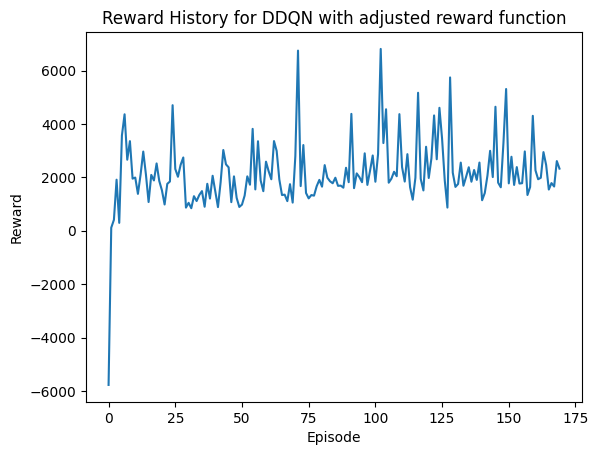

In [109]:
#plot reward history
import matplotlib.pyplot as plt
plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward History for DDQN with adjusted reward function')
plt.show()


In [110]:
# save model
agent.policy_model.save('./models/DDQN_RCmaze_ARF.h5')


/home/lucasdriessens/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### test

In [111]:
#test the model
# try it out
# load model
env = RCMazeEnv()
state = env.reset()

env.init_pygame()

REPLAY_MEMORY_CAPACITY = 20000
POSSIBLE_ACTIONS = env.possible_actions

# create DQN agent
test_agent = DQAgent(replayCapacity=REPLAY_MEMORY_CAPACITY, input_shape=state.shape, output_shape=len(POSSIBLE_ACTIONS))


from keras.models import load_model
test_agent.policy_model = load_model('./models/DDQN_RCmaze_ARF.h5')


done = False

rewards = []

while not done:
    env.render(delay=100, framerate=60)
   
    qValues = test_agent.policy_network_predict(np.array([state]))
    action = np.argmax(qValues[0])
    state, reward, done = env.step(action)
    rewards.append(reward)
    
    env.render()
    if done:
        print('done in ', len(rewards), 'steps')
        break
env.close()
print(sum(rewards))
env.close_pygame()


2024-01-09 12:43:20.473274: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_393/kernel/Assign' id:33594 op device:{requested: '', assigned: ''} def:{{{node dense_393/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_393/kernel, dense_393/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-09 12:43:22.486527: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_377_1/bias/Assign' id:34158 op device:{requested: '', assigned: ''} def:{{{node dense_377_1/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_377_1/bias, dense_377_1/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no 

done in  34 steps
1925.9848575566134


# adjusting network after testing with real sensors

In [5]:
import numpy as np

import gym
from gym import spaces

import pygame

class RCMazeEnv(gym.Env):
    def __init__(self, maze_size_x=12, maze_size_y=12):
        self.maze_size_x = maze_size_x
        self.maze_size_y = maze_size_y
        self.maze = self.generate_maze()
        self.car_position = (1, 1)
        self.possible_actions = range(3)
        self.car_orientation = 'N'
        self.sensor_readings = {'front': 0, 'left': 0, 'right': 0}
        self.steps = 0
        self.previous_distance = 0
        self.goal = (10, 10)
        self.previous_steps = 0
        self.visited_positions = set()
        self.reset()

            
    def generate_maze(self):
        # For simplicity, create a static maze with walls
        # '1' represents a wall, and '0' represents an open path
        maze = np.zeros((self.maze_size_y, self.maze_size_x), dtype=int)
        # Add walls to the maze (this can be customized)

        
        layout = [
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
            [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
            [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1],
            [1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1],
            [1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1],
            [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
        
     
        maze = np.array(layout)

        return maze

    def reset(self):
        self.car_position = (1, 1)
        self.car_orientation = 'N'
        self.update_sensor_readings()
        self.steps = 0
        self.previous_distance = 0
        self.previous_steps = 0
        self.visited_positions.clear()  # Clear the visited positions
        self.visited_positions.add(self.car_position)
        return self.get_state()

    def step(self, action):
        if action == 0:
            self.move_forward()
        elif action == 1:
            self.turn_left()
        elif action == 2:
            self.turn_right()
        self.update_sensor_readings()
        self.visited_positions.add(self.car_position)
        reward = self.compute_reward()
        self.steps += 1
        done = self.is_done()
        return self.get_state(), reward, done

    
    def move_forward(self):
        x, y = self.car_position
        if self.car_orientation == 'N' and y > 0 and self.maze[y - 1][x] != 1:
            self.car_position = (x, y - 1)
        elif self.car_orientation == 'S' and y < self.maze_size_y - 1 and self.maze[y + 1][x] != 1:
            self.car_position = (x, y + 1)
        elif self.car_orientation == 'E' and x < self.maze_size_x - 1 and self.maze[y][x + 1] != 1:
            self.car_position = (x + 1, y)
        elif self.car_orientation == 'W' and x > 0 and self.maze[y][x - 1] != 1:
            self.car_position = (x - 1, y)
        

    def turn_left(self):
        orientations = ['N', 'W', 'S', 'E']
        idx = orientations.index(self.car_orientation)
        self.car_orientation = orientations[(idx + 1) % 4]

    def turn_right(self):
        orientations = ['N', 'E', 'S', 'W']
        idx = orientations.index(self.car_orientation)
        self.car_orientation = orientations[(idx + 1) % 4]

    def update_sensor_readings(self):
        # Simple sensor implementation: counts steps to the nearest wall
        self.sensor_readings['front'] = self.distance_to_wall('front')
        self.sensor_readings['left'] = self.distance_to_wall('left')
        self.sensor_readings['right'] = self.distance_to_wall('right')

    def distance_to_wall(self, direction):
        x, y = self.car_position
        sensor_max_range = 255  # Maximum range of the ultrasonic sensor

        def calculate_distance(dx, dy):
            distance = 0
            while 0 <= x + distance * dx < self.maze_size_x and \
                0 <= y + distance * dy < self.maze_size_y and \
                self.maze[y + distance * dy][x + distance * dx] != 1:
                distance += 1
                if distance > sensor_max_range:  # Limiting the sensor range
                    break
            return distance

        if direction == 'front':
            if self.car_orientation == 'N':
                distance = calculate_distance(0, -1)
            elif self.car_orientation == 'S':
                distance = calculate_distance(0, 1)
            elif self.car_orientation == 'E':
                distance = calculate_distance(1, 0)
            elif self.car_orientation == 'W':
                distance = calculate_distance(-1, 0)

        elif direction == 'left':
            if self.car_orientation == 'N':
                distance = calculate_distance(-1, 0)
            elif self.car_orientation == 'S':
                distance = calculate_distance(1, 0)
            elif self.car_orientation == 'E':
                distance = calculate_distance(0, -1)
            elif self.car_orientation == 'W':
                distance = calculate_distance(0, 1)

        elif direction == 'right':
            if self.car_orientation == 'N':
                distance = calculate_distance(1, 0)
            elif self.car_orientation == 'S':
                distance = calculate_distance(-1, 0)
            elif self.car_orientation == 'E':
                distance = calculate_distance(0, 1)
            elif self.car_orientation == 'W':
                distance = calculate_distance(0, -1)

        # Normalize the distance to a range of 0-1
        normalized_distance = distance / sensor_max_range
        normalized_distance = max(0, min(normalized_distance, 1))

        return normalized_distance * 100
    
    def compute_reward(self):
        # Initialize reward
        reward = 0

        # Check for collision or out of bounds
        if any(self.sensor_readings[direction] == 0 for direction in ['front', 'left', 'right']):
            reward -= 50

        # Check if goal is reached
        if self.car_position == self.goal:
            reward += 500
            # Additional penalty if it takes too many steps to reach the goal
            if self.steps > 100:
                reward -= 200
            return reward  # Return immediately as this is the terminal state

        # Calculate the Euclidean distance to the goal
        distance_to_goal = ((self.car_position[0] - self.goal[0]) ** 2 + (self.car_position[1] - self.goal[1]) ** 2) ** 0.5

        # Define a maximum reward when the car is at the goal
        max_reward_at_goal = 100

        # Reward based on proximity to the goal
        reward += max_reward_at_goal / (distance_to_goal + 1)  # Adding 1 to avoid division by zero

        # # Reward or penalize based on movement towards or away from the goal
        if distance_to_goal < self.previous_distance:
            reward += 75  # Positive reward for moving closer to the goal
        # elif distance_to_goal > self.previous_distance:
        #     reward -= 75  # Negative reward for moving farther from the goal

        # each time it visits the same position more than 3 times it gets a penalty
        for position in self.visited_positions:
            times_in_position = sum([1 for pos in self.visited_positions if pos == position])
            if times_in_position >= 2:
                reward -= 25
        
            
        # Penalize for each step taken to encourage efficiency
        reward -= 20
        
        #if it doesnt move it gets a penalty
        if self.steps == self.previous_steps:
            reward -= 25
            
        
        # Update the previous_distance for the next step
        self.previous_distance = distance_to_goal
        return reward

    def is_done(self):
        #is done if it reaches the goal or goes out of bounds or takes more than 3000 steps
        return self.car_position == self.goal or self.steps > 3000 or self.car_position[0] < 0 or self.car_position[1] < 0 or self.car_position[0] > 11 or self.car_position[1] > 11
        
    def get_state(self):
        car_position = [float(coord) for coord in self.car_position]
        sensor_readings = [float(value) for value in self.sensor_readings.values()]
        
        state = car_position + [self.car_orientation] + sensor_readings
        
        # cast state to this ['1.0' '1.0' 'N' '1.0' '1.0' '10.0']
        state = np.array(state, dtype=str)
        
        #get the orientation and convert do label encoding
        if state[2] == 'N':
            state[2] = 0
        elif state[2] == 'E':
            state[2] = 1
        elif state[2] == 'S':
            state[2] = 2
        elif state[2] == 'W':
            state[2] = 3
            
        state = np.array(state, dtype=float)
        
        return state

    
    def init_pygame(self):
        # Initialize Pygame and set up the display
        pygame.init()
        self.cell_size = 40  # Size of each cell in pixels
        self.maze_size_x = 12  # Assuming the maze size_x is 12
        self.maze_size_y = 12  # Assuming the maze size_y is 12
        self.width = 600
        self.height = 600
        self.screen = pygame.display.set_mode((self.width, self.height))
        self.clock = pygame.time.Clock()

    def render(self, framerate=60, delay=0):
        # Render the environment using Pygame
        for y in range(self.maze_size_y):
            for x in range(self.maze_size_x):
                rect = pygame.Rect(x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size)
                if (x, y) == self.goal:  # Goal position
                    color = (0, 255, 0)  # Green color for the goal
                elif self.maze[y][x] == 0:
                    color = (255, 255, 255)  # White color for empty space
                else:
                    color = (0, 0, 0)  # Black color for walls
                pygame.draw.rect(self.screen, color, rect)
        
        # Draw the car
        car_x, car_y = self.car_position
        car_rect = pygame.Rect(car_x * self.cell_size, car_y * self.cell_size, self.cell_size, self.cell_size)
        pygame.draw.rect(self.screen, (255, 0, 0), car_rect)  # Red color for the car
        pygame.time.delay(delay)
        pygame.display.flip()
        self.clock.tick(framerate)  # Limit the frame rate to 60 FPS


    def close_pygame(self):
        # Close the Pygame window
        pygame.quit()

In [6]:
from tensorflow.keras.optimizers.legacy import Adam
class DQAgent:
    def __init__(self, replayCapacity, input_shape, output_shape, learning_rate=0.001, discount_factor=0.90):
        self.capacity = replayCapacity
        self.memory = collections.deque(maxlen=self.capacity)
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.policy_model = self.buildNetwork()
        self.target_model = self.buildNetwork()
        self.target_model.set_weights(self.policy_model.get_weights())


    def addToReplayMemory(self, step):
        self.step = step
        self.memory.append(self.step)

    def sampleFromReplayMemory(self, batchSize):
        self.batchSize = batchSize
        if self.batchSize > len(self.memory):
            self.populated = False
            return self.populated
        else:
            return random.sample(self.memory, self.batchSize)


    def buildNetwork(self):
        model = Sequential()
        model.add(Dense(128, input_shape=self.input_shape, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(self.output_shape, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate), metrics=['MeanSquaredError'])
        return model

    def policy_network_fit(self, batch, batch_size):
            states, actions, rewards, next_states, dones = zip(*batch)

            states = np.array(states)
            next_states = np.array(next_states)

            # Predict Q-values for starting state using the policy network
            q_values = self.policy_model.predict(states)

            # Predict Q-values for next state using the policy network
            q_values_next_state_policy = self.policy_model.predict(next_states)

            # Select the best action for the next state using the policy network
            best_actions = np.argmax(q_values_next_state_policy, axis=1)

            # Predict Q-values for next state using the target network
            q_values_next_state_target = self.target_model.predict(next_states)

            # Update Q-values for actions taken
            for i in range(batch_size):
                if dones[i]:
                    q_values[i, actions[i]] = rewards[i]
                else:
                    # Double DQN update rule
                    q_values[i, actions[i]] = rewards[i] + self.discount_factor * q_values_next_state_target[i, best_actions[i]]

            # Train the policy network
            self.policy_model.fit(states, q_values, batch_size=batch_size, verbose=0)

    def policy_network_predict(self, state):
        self.state = state
        self.qPolicy = self.policy_model.predict(self.state)
        return self.qPolicy

    def target_network_predict(self, state):
        self.state = state
        self.qTarget = self.target_model.predict(self.state)
        return self.qTarget

    def update_target_network(self):
        self.target_model.set_weights(self.policy_model.get_weights())

In [7]:
env = RCMazeEnv()
state = env.reset()

env.init_pygame()

# Model parameters
REPLAY_MEMORY_CAPACITY = 200000
# MIN_REPLAY_MEMORY_SIZE = 1_000  # Minimum number of steps in a memory to start training
POSSIBLE_ACTIONS = env.possible_actions

# state = state[0]
# create DQN agent
agent = DQAgent(replayCapacity=REPLAY_MEMORY_CAPACITY, 
                input_shape=state.shape, 
                output_shape=len(POSSIBLE_ACTIONS),
                learning_rate=0.001, 
                discount_factor=0.90)


# reset the parameters
DISCOUNT = 0.90
BATCH_SIZE = 64  # How many steps (samples) to use for training
UPDATE_TARGET_INTERVAL = 2
EPSILON = 0.9 # Exploration percentage
MIN_EPSILON = 0.001
DECAY = 0.99999
EPISODE_AMOUNT = 170



# Fill the replay memory with the first batch of samples
update_counter = 0
reward_history = []
epsilon_history = []

np.set_printoptions(precision=3, suppress=True)

for episode in range(EPISODE_AMOUNT):
    episode_reward = 0
    step_counter = 0  # count the number of successful steps within the episode
    
    state = env.reset()
    done = False
    epsilon_history.append(EPSILON)
    
   #  early stopping
    if len(reward_history) > 10:
        last_10_rewards = reward_history[-10:]
        if all(reward > 0 for reward in last_10_rewards):
            differences = [abs(last_10_rewards[i] - last_10_rewards[i-1]) for i in range(1, 10)]
            if all(diff < 200 for diff in differences):
                print('The difference between each of the last 10 positive rewards is less than 200, stopping training')
                break
    while not done:
        env.render(delay=0, framerate=360)

        if random.random() <= EPSILON:
            action = random.sample(POSSIBLE_ACTIONS, 1)[0]
        else:
            qValues = agent.policy_network_predict(state.reshape(1,-1))
            action = np.argmax(qValues[0])

        new_state, reward, done = env.step(action)

        step_counter +=1

        # store step in replay memory
        step = (state, action, reward, new_state, done)
        agent.addToReplayMemory(step)
        state = new_state
        episode_reward += reward
        # When enough steps in replay memory -> train policy network
        if len(agent.memory) >= BATCH_SIZE * 2:
            EPSILON = DECAY * EPSILON
            if EPSILON < MIN_EPSILON:
                EPSILON = MIN_EPSILON
            # sample minibatch from replay memory
            
            miniBatch = agent.sampleFromReplayMemory(BATCH_SIZE)
            miniBatch_states = np.asarray(list(zip(*miniBatch))[0],dtype=float)
            miniBatch_actions = np.asarray(list(zip(*miniBatch))[1], dtype = int)
            miniBatch_rewards = np.asarray(list(zip(*miniBatch))[2], dtype = float)
            miniBatch_next_state = np.asarray(list(zip(*miniBatch))[3],dtype=float)
            miniBatch_done = np.asarray(list(zip(*miniBatch))[4],dtype=bool)
            
            # current state q values1tch_states)
            y = agent.policy_network_predict(miniBatch_states)

            next_state_q_values = agent.target_network_predict(miniBatch_next_state)
            max_q_next_state = np.max(next_state_q_values,axis=1)

            for i in range(BATCH_SIZE):
                if miniBatch_done[i]:
                    y[i,miniBatch_actions[i]] = miniBatch_rewards[i]
                else:
                    y[i,miniBatch_actions[i]] = miniBatch_rewards[i] + DISCOUNT *  max_q_next_state[i]
                    
            agent.policy_model.fit(miniBatch_states, y, batch_size=BATCH_SIZE, verbose = 0)
            
        else:
            continue
        if update_counter == UPDATE_TARGET_INTERVAL:
            agent.update_target_network()
            update_counter = 0
        update_counter += 1
    print('episodeReward for episode ', episode, '= ', episode_reward, 'with epsilon = ', EPSILON)
    reward_history.append(episode_reward)
    

env.close_pygame()
env.close()

C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


episodeReward for episode  0 =  -7515.3126996378005 with epsilon =  0.8745020333590038
episodeReward for episode  1 =  1436.7176489038916 with epsilon =  0.869244626821912
episodeReward for episode  2 =  -102.99074673951026 with epsilon =  0.863949708126641
episodeReward for episode  3 =  1665.7893945597934 with epsilon =  0.8595461637384804
episodeReward for episode  4 =  799.9660950432499 with epsilon =  0.8568257030055244
episodeReward for episode  5 =  1551.7382233894962 with epsilon =  0.8559521819923016
episodeReward for episode  6 =  3163.6917874330247 with epsilon =  0.8484867498836193
episodeReward for episode  7 =  2028.7223839890514 with epsilon =  0.8429557250497581
episodeReward for episode  8 =  304.26146665687094 with epsilon =  0.8377455417617333
episodeReward for episode  9 =  2093.6041776396555 with epsilon =  0.8351358358810752
episodeReward for episode  10 =  1272.3370221879472 with epsilon =  0.8327007839710162
episodeReward for episode  11 =  1891.726161905568 wit

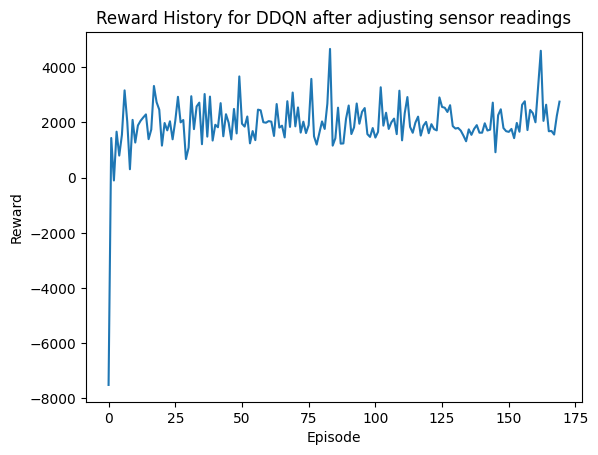

In [8]:
#plot reward history
import matplotlib.pyplot as plt
plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward History for DDQN after adjusting sensor readings')
plt.show()


In [9]:
#save model
agent.policy_model.save('./models/DDQN_RCmaze_ASRA.h5')


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#test the model
# try it out
# load model
env = RCMazeEnv()
state = env.reset()

env.init_pygame()

REPLAY_MEMORY_CAPACITY = 20000
POSSIBLE_ACTIONS = env.possible_actions

# create DQN agent
test_agent = DQAgent(replayCapacity=REPLAY_MEMORY_CAPACITY, input_shape=state.shape, output_shape=len(POSSIBLE_ACTIONS))


from keras.models import load_model
test_agent.policy_model = load_model('./models/DDQN_RCmaze_ASRA.h5')


done = False

rewards = []

while not done:
    env.render(delay=100, framerate=60)
   
    qValues = test_agent.policy_network_predict(np.array([state]))
    action = np.argmax(qValues[0])
    state, reward, done = env.step(action)
    rewards.append(reward)
    
    env.render()
    if done:
        print('done in ', len(rewards), 'steps')
        break
env.close()
print(sum(rewards))
env.close_pygame()
